In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [4]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['GarageType_Detchd', 'MSSubClass_120', 'ExterQual_Ex', 'SaleType_Con', 'GarageQual_Po', 'HeatingQC_TA', 'HouseStyle_1Story', 'BldgType_TwnhsE', 'BsmtExposure_Mn', 'HouseStyle_2Story', 'Exterior2nd_Brk Cmn', 'ExterCond_Ex', 'ExterCond_Po', 'Foundation_BrkTil', 'Foundation_CBlock', 'Functional_Mod', 'OverallQual_6', 'Exterior1st_CBlock', 'Neighborhood_StoneBr', 'Condition1_RRNn', 'GarageType_CarPort', 'Exterior1st_BrkComm', 'LandContour_HLS', 'SaleCondition_Partial', 'GarageCond_TA', 'Condition1_RRAn', 'Exterior1st_Wd Sdng', 'HouseStyle_2.5Fin', 'Exter

In [5]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [6]:
df[cat_features].describe()

,GarageType_Detchd,MSSubClass_120,ExterQual_Ex,SaleType_Con,GarageQual_Po,HeatingQC_TA,HouseStyle_1Story,BldgType_TwnhsE,BsmtExposure_Mn,HouseStyle_2Story,...,LotShape_IR2,Neighborhood_NAmes,Electrical_FuseF,MSSubClass_70,MasVnrType_Stone,Exterior1st_Stone,Neighborhood_SawyerW,LotConfig_Corner,LotConfig_CulDSac,GarageType_2Types
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.265068,0.059589,0.035616,0.001370,0.002055,0.293151,0.497260,0.078082,0.078082,0.304795,...,0.028082,0.154110,0.018493,0.041096,0.087671,0.001370,0.040411,0.180137,0.064384,0.004110
std,0.441521,0.236805,0.185395,0.036999,0.045299,0.455363,0.500164,0.268393,0.268393,0.460478,...,0.165264,0.361177,0.134772,0.198580,0.282913,0.036999,0.196989,0.384433,0.245519,0.063996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print (df.shape)

(1460, 320)


In [8]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

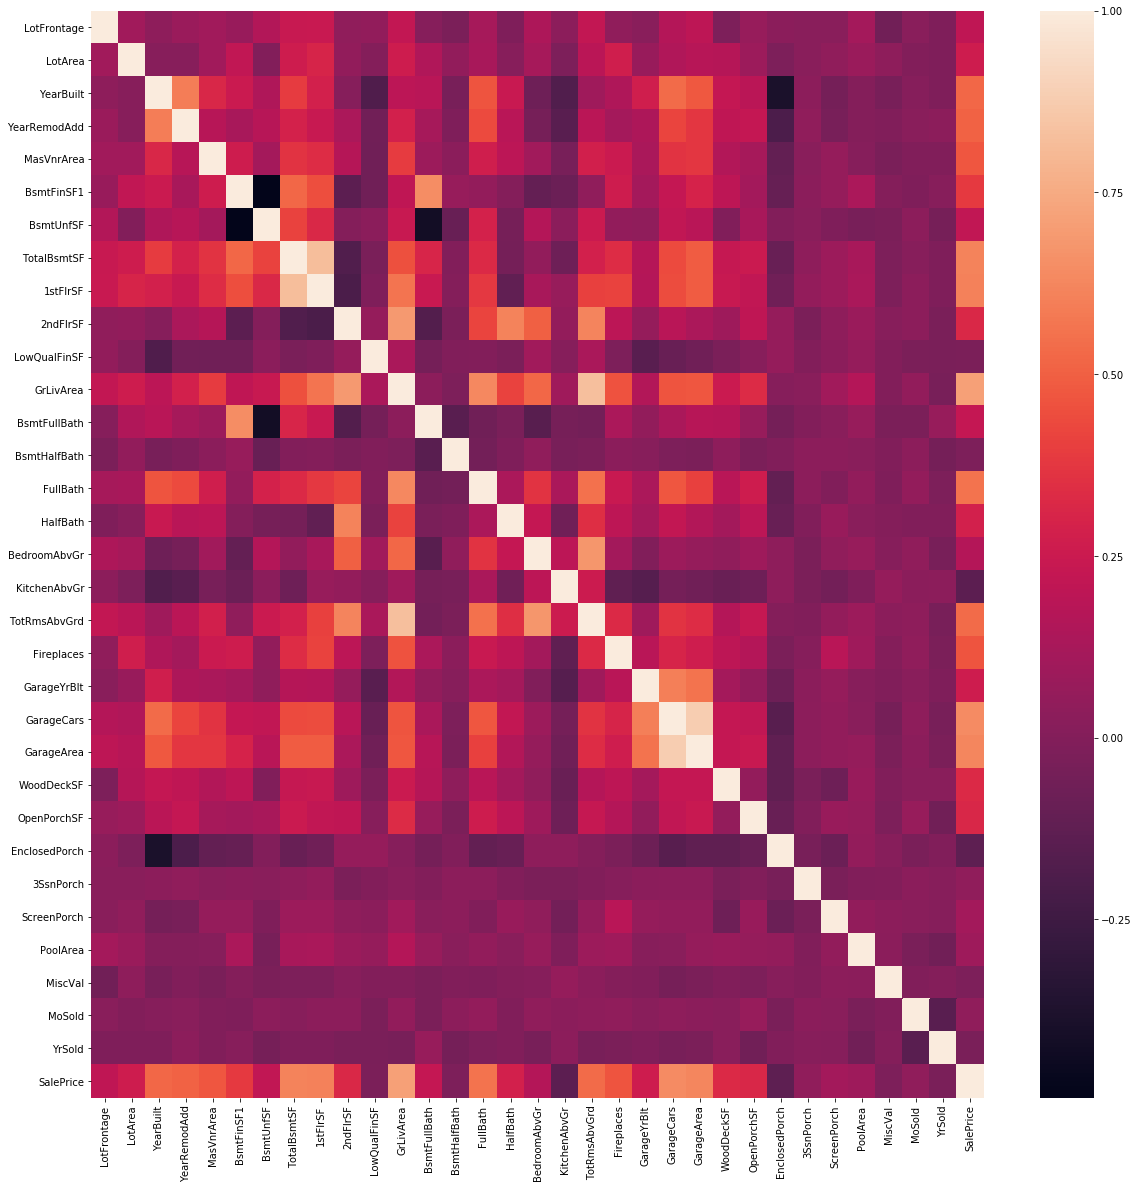

In [9]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

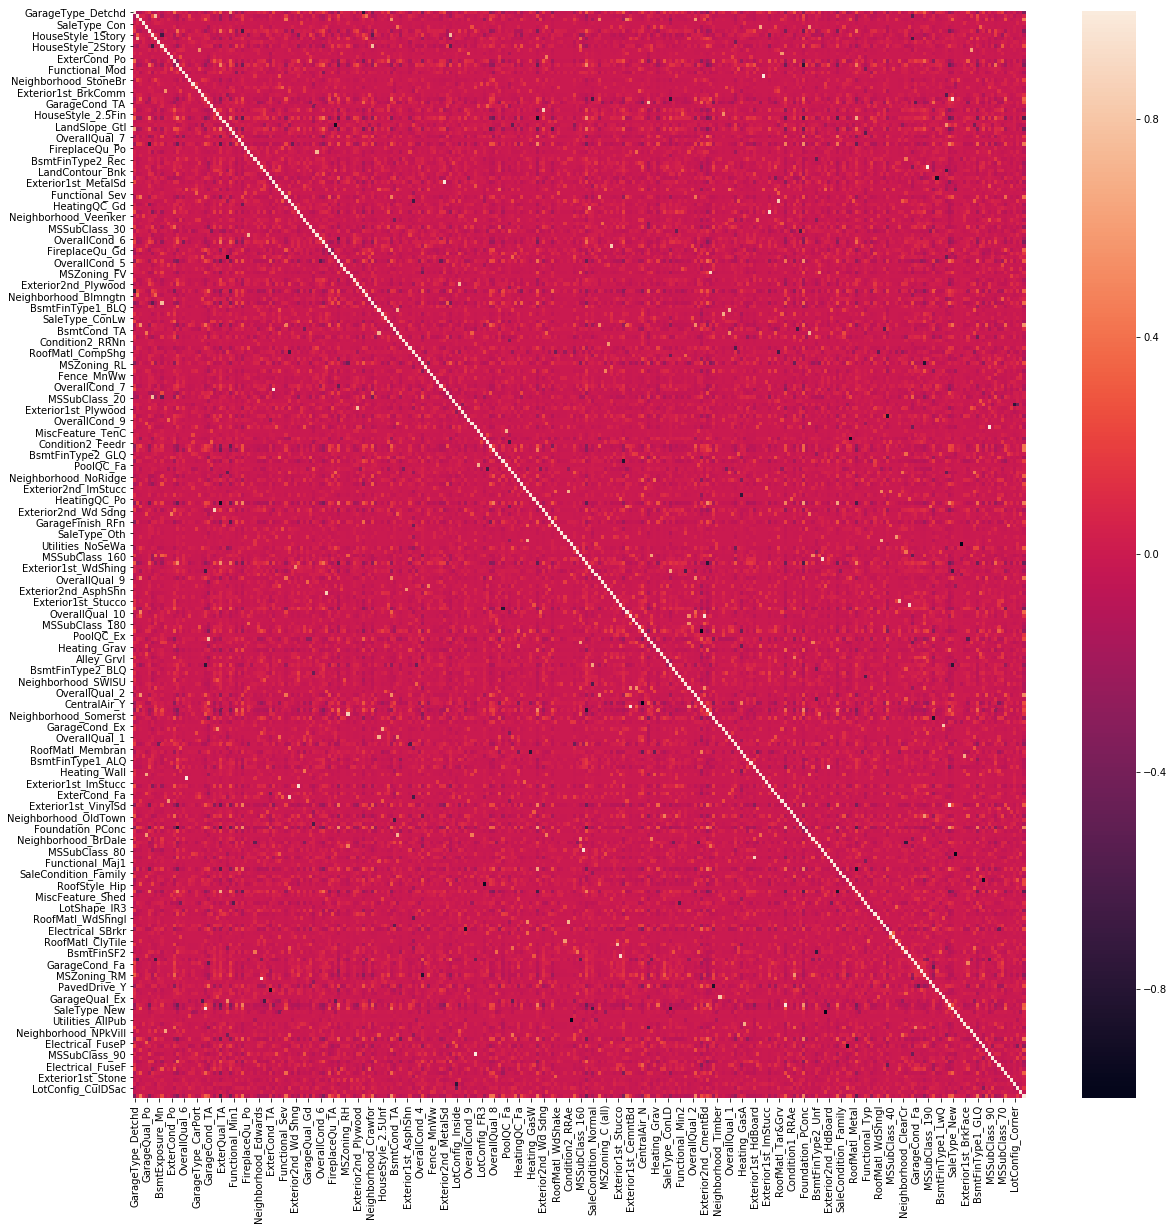

In [10]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

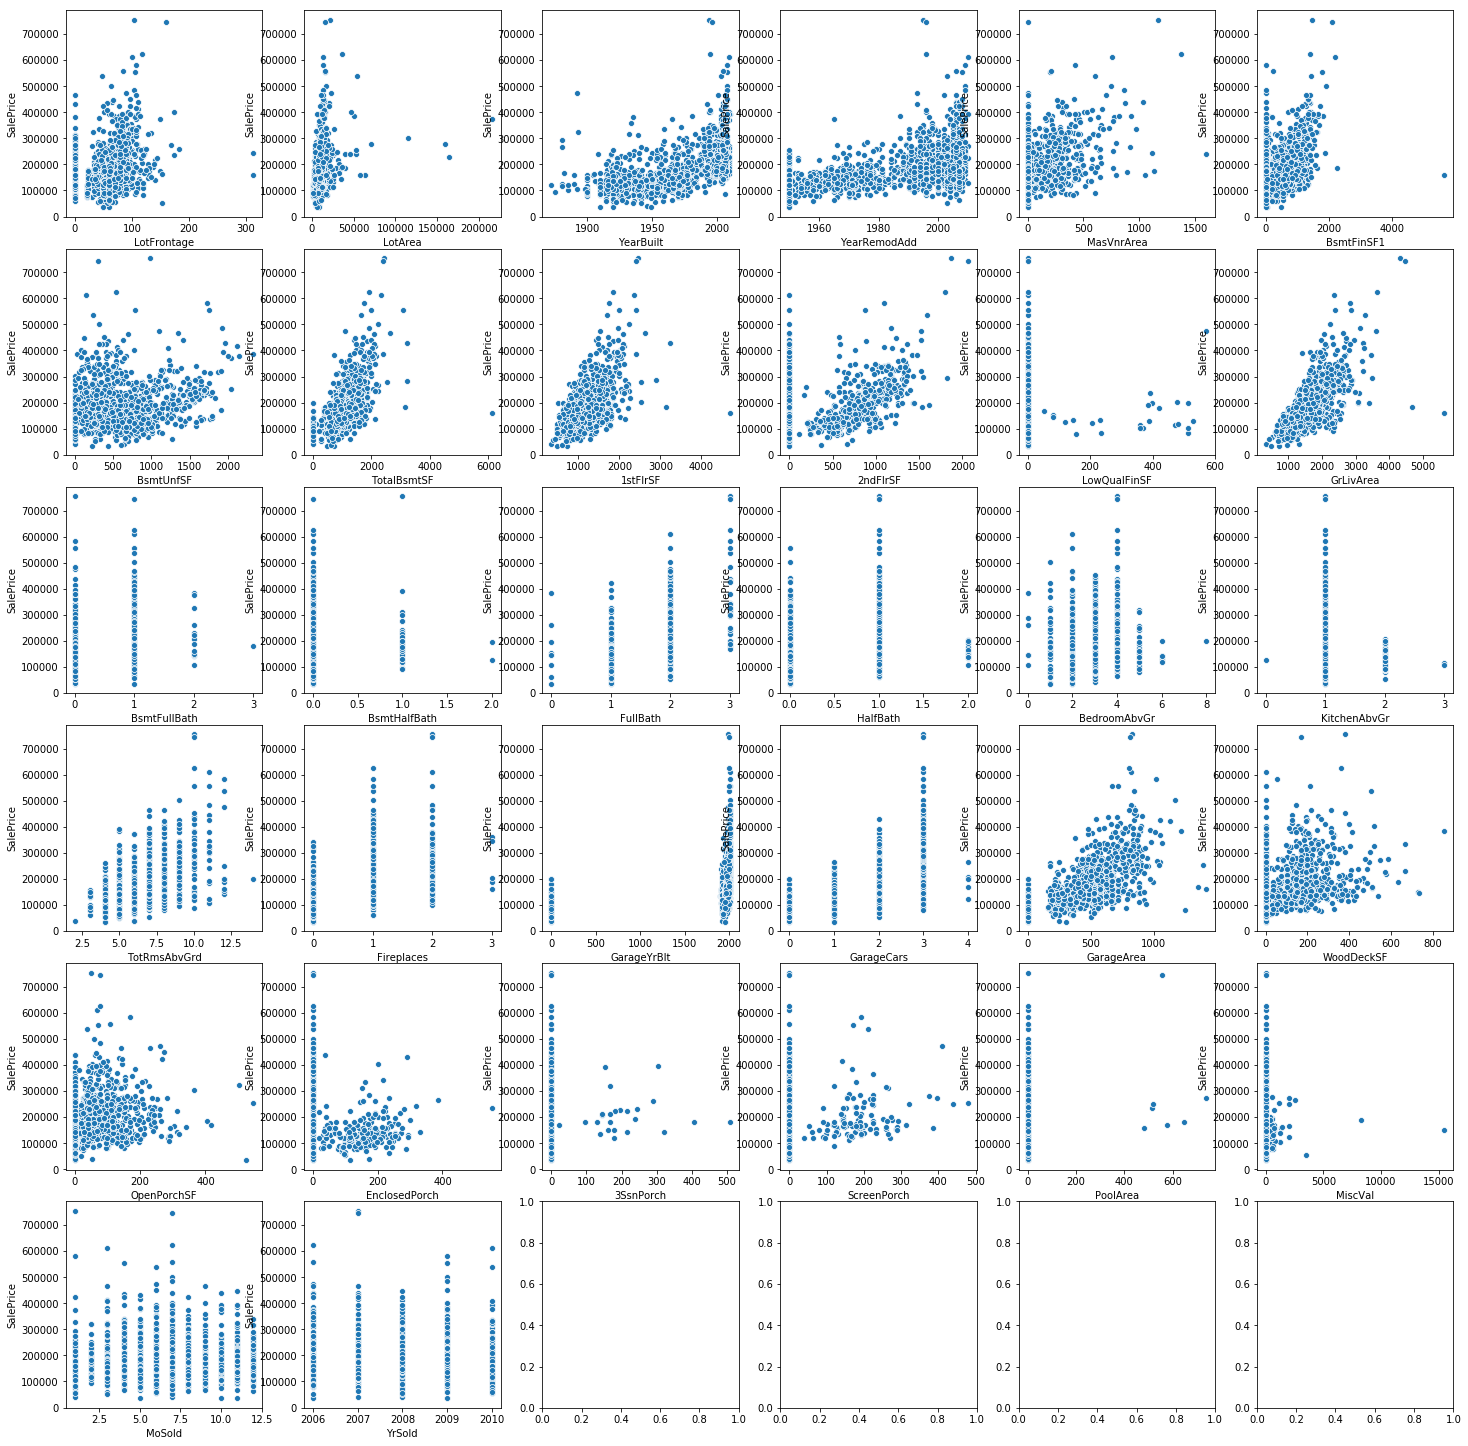

In [11]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [12]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0] 
y: 208500 


### Polynomial features

In [13]:
#transform = PolynomialFeatures(2)
#X_poly_real = transform.fit_transform(X_real)
X_poly_real = X_real

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [15]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 32)
(1460, 287)
(1460,)


### Checking dataset

In [16]:
#(X_train_real, X_test_real, X_train_cat, X_test_cat, 
# y_train, y_test) = train_test_split(X_real_scaled, X_cat, y, test_size=0.3, random_state=0)
#print (X_train_real.shape, X_test_real.shape)
#print (X_train_cat.shape, X_test_cat.shape)

#print (y_train.shape, y_test.shape)

In [17]:
#X_train = np.hstack((X_train_real, X_train_cat))
#X_test = np.hstack((X_test_real, X_test_cat))
X = np.hstack((X_real_scaled, X_cat))

In [18]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [19]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score

In [21]:
param_grid = {
    'alpha': [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0], 'max_iter': [100000]
}
estimator = Lasso()

ls_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ls_model.fit(X, y)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] alpha=20.0, max_iter=100000 .....................................
[CV] alpha=20.0, max_iter=100000 .....................................
[CV] alpha=20.0, max_iter=100000 .....................................
[CV] alpha=20.0, max_iter=100000 .....................................
[CV]  alpha=20.0, max_iter=100000, score=0.9271001567081383, total=   7.5s
[CV] alpha=20.0, max_iter=100000 .....................................
[CV]  alpha=20.0, max_iter=100000, score=0.9064639463257088, total=   8.0s
[CV] alpha=20.0, max_iter=100000 .....................................
[CV]  alpha=20.0, max_iter=100000, score=0.8885045368899065, total=   8.3s
[CV] alpha=20.0, max_iter=100000 .....................................
[CV]  alpha=20.0, max_iter=100000, score=0.7454511497581751, total=   8.7s
[CV] alpha=20.0, max_iter=100000 .....................................
[CV]  alpha=20.0, max_iter=100000, score=0.9139869700848499, total=   7

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.6s


[CV]  alpha=40.0, max_iter=100000, score=0.9126990473125571, total=   3.7s
[CV] alpha=40.0, max_iter=100000 .....................................
[CV]  alpha=40.0, max_iter=100000, score=0.7742030720929263, total=   4.5s
[CV] alpha=40.0, max_iter=100000 .....................................
[CV]  alpha=40.0, max_iter=100000, score=0.902427679282426, total=   3.8s
[CV] alpha=50.0, max_iter=100000 .....................................
[CV]  alpha=40.0, max_iter=100000, score=0.5843065898994159, total=   3.4s
[CV] alpha=50.0, max_iter=100000 .....................................
[CV]  alpha=40.0, max_iter=100000, score=0.9152010951895996, total=   4.0s
[CV] alpha=50.0, max_iter=100000 .....................................
[CV]  alpha=40.0, max_iter=100000, score=0.8984342318426279, total=   3.8s
[CV] alpha=50.0, max_iter=100000 .....................................
[CV]  alpha=50.0, max_iter=100000, score=0.9130775639798104, total=   2.9s
[CV] alpha=50.0, max_iter=100000 .................

[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.9193346740739881, total=   2.0s
[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.9331877230644903, total=   1.1s
[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.904712001157614, total=   1.2s
[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.7474679876665838, total=   2.2s
[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.9064093211578153, total=   2.0s
[CV] alpha=100.0, max_iter=100000 ....................................
[CV]  alpha=100.0, max_iter=100000, score=0.8378351341706556, total=   2.4s
[CV]  alpha=100.0, max_iter=100000, score=0.5894643423353564, total=   1.1s
[CV]  alpha=100.0, max_iter=100000, score=0

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0], 'max_iter': [100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [22]:
print (ls_model.best_estimator_)

Lasso(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [23]:
print (ls_model.best_score_)

0.8564904533596935


In [24]:
c = 0
not_null_idx = []
for cf in ls_model.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

116
[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 38, 41, 50, 60, 65, 67, 72, 74, 76, 77, 81, 90, 93, 97, 98, 103, 104, 108, 114, 115, 116, 118, 124, 129, 131, 133, 134, 138, 140, 145, 148, 155, 158, 163, 164, 167, 169, 174, 176, 180, 182, 184, 190, 191, 195, 199, 205, 206, 210, 211, 213, 217, 218, 226, 232, 245, 248, 252, 260, 262, 265, 268, 270, 271, 272, 274, 275, 278, 281, 283, 284, 286, 287, 291, 292, 294, 295, 296, 300, 301, 304, 309, 310, 313, 315, 316, 317]


In [25]:
X = X[:, not_null_idx]
print (X.shape)

(1460, 116)


### SVR

In [26]:
from sklearn.svm import SVR

In [27]:
svr_model = SVR(kernel='linear', C=50.0, epsilon=1.0)

score = cross_val_score(svr_model, X, y, cv=10)
score_mean = score.mean()

In [28]:
print (score_mean)

0.7728743884290289


In [29]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'degree': [1],
    'C': [400.0, 450.0, 500.0, 550.0, 600.0],
    'epsilon': [0.01, 0.02, 0.05, 0.1, 0.5, 1.0]
}
estimator = SVR()

svr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
svr2_model.fit(X, y)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=100.0, degree=1, epsilon=0.05, kernel=linear, score=0.8772732271965972, total=   2.2s
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=100.0, degree=1, epsilon=0.05, kernel=linear, score=0.8264046887575591, total=   3.0s
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=100.0, degree=1, epsilon=0.05, kernel=linear, score=0.8881111232902201, total=   5.4s
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=100.0, degree=1, epsilon=0.05, kernel=linear, score=0.7549072127870627, total=   6.5s
[CV] C=100.0, degree=1, epsilon=0.05, kernel=linear ..........

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.0s


[CV]  C=100.0, degree=1, epsilon=0.1, kernel=linear, score=0.8057542907606823, total=   4.1s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.1, kernel=linear, score=0.8373612908919545, total=   4.0s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.1, kernel=linear, score=0.8470912522133617, total=   2.8s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=100.0, degree=1, epsilon=0.1, kernel=rbf, score=0.09082136453835121, total=   0.4s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=100.0, degree=1, epsilon=0.1, kernel=rbf, score=-0.02040083136964732, total=   0.4s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=100.0, degree=1, epsilon=0.1, kernel=linear, score=0.8673952234832653, total=   2.3s
[CV] C=100.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=100.0, degr

[CV] C=100.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=100.0, degree=1, epsilon=0.3, kernel=rbf, score=0.01907284788682706, total=   0.5s
[CV] C=100.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=100.0, degree=1, epsilon=0.3, kernel=rbf, score=0.07801096347421932, total=   0.8s
[CV] C=100.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.3, kernel=rbf, score=-0.022924408965680376, total=   0.7s
[CV] C=100.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.3, kernel=rbf, score=0.09197562639541323, total=   0.7s
[CV] C=100.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.3, kernel=rbf, score=0.07824163826023889, total=   0.8s
[CV] C=100.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=0.4, kernel=linear, score=0.8772734722833252, total=   1.8s
[CV] C=100.0, degree=1, 

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min


[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.8772738929236997, total=   1.6s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.8264074124671836, total=   2.4s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.888111252918767, total=   4.2s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.7549075644778466, total=   4.8s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.8057518456141552, total=   4.7s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, degree=1, epsilon=1.0, kernel=linear, score=0.8373611951501396, total=   4.2s
[CV] C=100.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=100.0, de

[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=rbf, score=0.07241577376676989, total=   0.8s
[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=rbf, score=0.05826581780575202, total=   0.8s
[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=linear, score=0.8642437325315875, total=  10.6s
[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=rbf, score=0.06365216850077793, total=   0.7s
[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=rbf, score=0.12380518552589515, total=   1.1s
[CV] C=150.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=0.1, kernel=rbf, score=0.1424863973289685, total=   1.1s
[CV] C=150.0, degree=1, eps

[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.8883710043551841, total=   4.4s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.7622311631839205, total=   3.3s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.9039206870235446, total=   4.3s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.8288417728662628, total=   4.3s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.8585962699575633, total=   6.7s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=150.0, degree=1, epsilon=0.4, kernel=linear, score=0.8526710534038582, total=   8.1s
[CV] C=150.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=150.0, d

[CV]  C=150.0, degree=1, epsilon=1.0, kernel=rbf, score=0.07241677127027057, total=   0.5s
[CV] C=150.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV] C=150.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=1.0, kernel=rbf, score=0.05826358563374767, total=   0.5s
[CV] C=150.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=1.0, kernel=linear, score=0.8799190216933473, total=   3.2s
[CV] C=150.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=1.0, kernel=rbf, score=0.12380719509398086, total=   0.7s
[CV] C=150.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=150.0, degree=1, epsilon=1.0, kernel=rbf, score=0.06365361346506315, total=   0.7s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=150.0, degree=1, epsilon=1.0, kernel=rbf, score=0.14248975903507477, total=   0.7s
[CV]  C=150.0, degree=1, e

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.8min


[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.912023336997206, total=   8.9s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.765400877819109, total=   9.1s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.8521580459650676, total=  11.2s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.8962183131136051, total=  12.7s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.8385550517413078, total=  12.8s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.0, degree=1, epsilon=0.05, kernel=linear, score=0.8732687449090263, total=  11.1s
[CV] C=200.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=200.

[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=linear, score=0.886719897496478, total=   5.4s
[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=rbf, score=0.10980337283712693, total=   0.5s
[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=rbf, score=0.08936498581113339, total=   0.5s
[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=rbf, score=0.10002308390308634, total=   0.5s
[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=rbf, score=0.16540850588080358, total=   0.6s
[CV] C=200.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=200.0, degree=1, epsilon=0.2, kernel=rbf, score=0.1889356387442687, total=   0.5s
[CV] C=200.0, degree=1, epsi

[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.9120236782765172, total=   6.4s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.8521574262740557, total=   7.4s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.7654006194703833, total=   5.6s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.8385555355660429, total=   8.4s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.8696692672628797, total=   7.2s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=200.0, degree=1, epsilon=0.5, kernel=linear, score=0.8732680292456088, total=   8.3s
[CV] C=200.0, degree=1, epsilon=0.5, kernel=rbf ......................
[CV]  C=200.0, d

[CV] C=250.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=rbf, score=0.13433129066401817, total=   0.4s
[CV] C=250.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=linear, score=0.8771432603232027, total=  10.4s
[CV] C=250.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=linear, score=0.8929691529751336, total=   5.1s
[CV] C=250.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=rbf, score=0.20274224922406667, total=   0.5s
[CV] C=250.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=rbf, score=0.22993649434520147, total=   0.5s
[CV] C=250.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.05, kernel=rbf, score=0.0615503415536639, total=   0.5s
[CV] C=250.0, degre

[CV]  C=250.0, degree=1, epsilon=0.3, kernel=linear, score=0.848324562924121, total=   6.3s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.3, kernel=linear, score=0.9026500387039244, total=  15.4s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.3, kernel=linear, score=0.8787503320528405, total=   7.9s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.3, kernel=linear, score=0.8693420324330265, total=   8.9s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.3, kernel=linear, score=0.7662865670489282, total=  18.3s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=0.3, kernel=rbf, score=0.23681276993207753, total=   0.4s
[CV] C=250.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=250.0, degr

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  9.0min


[CV]  C=250.0, degree=1, epsilon=0.4, kernel=linear, score=0.8787505255325091, total=   7.6s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.4, kernel=linear, score=0.8693422467084425, total=  11.0s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=250.0, degree=1, epsilon=0.4, kernel=linear, score=0.7662863483556873, total=  18.5s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=0.4, kernel=rbf, score=0.23681272706064826, total=   0.4s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=0.4, kernel=rbf, score=0.10550950741252907, total=   0.4s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=0.4, kernel=rbf, score=0.16974185768741834, total=   0.4s
[CV] C=250.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=250.0, degree=

[CV] C=250.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=1.0, kernel=rbf, score=0.20274355638531916, total=   0.5s
[CV] C=250.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=250.0, degree=1, epsilon=1.0, kernel=rbf, score=0.22993442655927787, total=   0.5s
[CV] C=300.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=250.0, degree=1, epsilon=1.0, kernel=rbf, score=0.06154633692668022, total=   0.5s
[CV] C=300.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=250.0, degree=1, epsilon=1.0, kernel=rbf, score=0.21244060929814557, total=   0.5s
[CV] C=300.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=300.0, degree=1, epsilon=0.05, kernel=linear, score=0.9203402242288828, total=   4.7s
[CV] C=300.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=250.0, degree=1, epsilon=1.0, kernel=linear, score=0.5674380544566686, total=  16.9s
[CV] C=300.0, degree=1,

[CV]  C=300.0, degree=1, epsilon=0.2, kernel=linear, score=0.8550482638956596, total=  11.8s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.2, kernel=linear, score=0.885238982312568, total=   7.9s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=300.0, degree=1, epsilon=0.2, kernel=rbf, score=0.27736640178793537, total=   0.4s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=300.0, degree=1, epsilon=0.2, kernel=rbf, score=0.1403001945347151, total=   0.4s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=300.0, degree=1, epsilon=0.2, kernel=rbf, score=0.2055375716037663, total=   0.4s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=300.0, degree=1, epsilon=0.2, kernel=rbf, score=0.17477180609606469, total=   0.4s
[CV] C=300.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=300.0, degree=1, ep

[CV] C=300.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=300.0, degree=1, epsilon=0.4, kernel=rbf, score=0.08385591290370686, total=   0.5s
[CV] C=300.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.4, kernel=rbf, score=0.25029358297771676, total=   0.4s
[CV] C=300.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.4, kernel=linear, score=0.8972895368575514, total=  10.2s
[CV] C=300.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.4, kernel=linear, score=0.8823690469857788, total=  17.2s
[CV] C=300.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.5, kernel=linear, score=0.9203408302657066, total=   4.4s
[CV] C=300.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=300.0, degree=1, epsilon=0.5, kernel=linear, score=0.8665943342179266, total=   9.6s
[CV] C=300.0, degree

[CV]  C=350.0, degree=1, epsilon=0.05, kernel=linear, score=0.879045754039711, total=  21.2s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degree=1, epsilon=0.05, kernel=linear, score=0.8866202211610937, total=  19.6s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degree=1, epsilon=0.05, kernel=rbf, score=0.31646100876679717, total=   0.5s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degree=1, epsilon=0.05, kernel=rbf, score=0.17041265315819132, total=   0.5s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degree=1, epsilon=0.05, kernel=rbf, score=0.23973919040196734, total=   0.5s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degree=1, epsilon=0.05, kernel=rbf, score=0.20714018710932192, total=   0.5s
[CV] C=350.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=350.0, degr

[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.2, kernel=rbf, score=0.2862588766685846, total=   0.5s
[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.2, kernel=linear, score=0.9003275583378724, total=  12.4s
[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.2, kernel=linear, score=0.570434975226074, total=  19.2s
[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.3, kernel=linear, score=0.9092868900633588, total=  11.5s
[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.3, kernel=linear, score=0.8681957552177612, total=  12.4s
[CV] C=350.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.3, kernel=linear, score=0.7701495977972581, total=  12.0s
[CV] C=350.0, degree

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.7min


[CV]  C=350.0, degree=1, epsilon=0.4, kernel=rbf, score=0.19385106955118825, total=   0.4s
[CV] C=350.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=350.0, degree=1, epsilon=0.4, kernel=rbf, score=0.26975542122916407, total=   0.4s
[CV] C=350.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=350.0, degree=1, epsilon=0.4, kernel=rbf, score=0.3039476419953261, total=   0.4s
[CV] C=350.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=350.0, degree=1, epsilon=0.4, kernel=rbf, score=0.10502393061511439, total=   0.4s
[CV] C=350.0, degree=1, epsilon=0.4, kernel=rbf ......................
[CV]  C=350.0, degree=1, epsilon=0.4, kernel=rbf, score=0.28625831722539063, total=   0.4s
[CV] C=350.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=350.0, degree=1, epsilon=0.4, kernel=linear, score=0.8866203801971144, total=  15.7s
[CV] C=350.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=350.0, degree=1, ep

[CV] C=400.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=linear, score=0.7715491401098855, total=  15.0s
[CV] C=400.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=linear, score=0.8613057320394419, total=  13.9s
[CV] C=400.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=linear, score=0.8819865638560123, total=  16.9s
[CV] C=400.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=linear, score=0.8901178371072678, total=  13.6s
[CV] C=400.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=rbf, score=0.3533325402233044, total=   0.4s
[CV] C=400.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=400.0, degree=1, epsilon=0.05, kernel=rbf, score=0.20123557699565342, total=   0.4s
[CV] C=400.0, d

[CV]  C=400.0, degree=1, epsilon=0.2, kernel=rbf, score=0.29970064177040867, total=   0.4s
[CV] C=400.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.2, kernel=linear, score=0.8901181394675433, total=  14.4s
[CV] C=400.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.2, kernel=rbf, score=0.3362876353521861, total=   0.5s
[CV] C=400.0, degree=1, epsilon=0.2, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.2, kernel=rbf, score=0.12615062566590007, total=   0.5s
[CV] C=400.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=400.0, degree=1, epsilon=0.2, kernel=rbf, score=0.31972452922043537, total=   0.5s
[CV] C=400.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=400.0, degree=1, epsilon=0.2, kernel=linear, score=0.5717064247968391, total=  14.2s
[CV] C=400.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=400.0, degree=1, 

[CV] C=400.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=linear, score=0.8613064975110437, total=  15.7s
[CV] C=400.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=linear, score=0.8819857520275688, total=  17.4s
[CV] C=400.0, degree=1, epsilon=0.5, kernel=linear ...................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=linear, score=0.8917316075743364, total=  17.6s
[CV] C=400.0, degree=1, epsilon=0.5, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=rbf, score=0.3533290309602849, total=   0.5s
[CV] C=400.0, degree=1, epsilon=0.5, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=rbf, score=0.20123512440637248, total=   0.5s
[CV] C=400.0, degree=1, epsilon=0.5, kernel=rbf ......................
[CV]  C=400.0, degree=1, epsilon=0.5, kernel=rbf, score=0.27140411870616354, total=   0.4s
[CV] C=400.0, degree=1,

[CV]  C=450.0, degree=1, epsilon=0.05, kernel=rbf, score=0.36222225979010214, total=   0.4s
[CV] C=450.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=450.0, degree=1, epsilon=0.05, kernel=rbf, score=0.14445639443863723, total=   0.4s
[CV] C=450.0, degree=1, epsilon=0.05, kernel=rbf .....................
[CV]  C=450.0, degree=1, epsilon=0.05, kernel=rbf, score=0.3467786267374626, total=   0.4s
[CV] C=450.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.05, kernel=linear, score=0.5752161148443793, total=  17.9s
[CV] C=450.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.05, kernel=linear, score=0.8937708062981943, total=  21.1s
[CV] C=450.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.1, kernel=linear, score=0.8715809662494145, total=  11.8s
[CV] C=450.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=450.0, deg

[CV] C=450.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=linear, score=0.8834937168162673, total=  16.2s
[CV] C=450.0, degree=1, epsilon=0.3, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=linear, score=0.5752177771551532, total=  16.6s
[CV] C=450.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=rbf, score=0.38121189662634847, total=   0.4s
[CV] C=450.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=rbf, score=0.22618349740153565, total=   0.4s
[CV] C=450.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=linear, score=0.8937708697743451, total=  19.6s
[CV] C=450.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=450.0, degree=1, epsilon=0.3, kernel=rbf, score=0.2981140457608301, total=   0.5s
[CV] C=450.0, degree=1,

[CV]  C=450.0, degree=1, epsilon=0.5, kernel=linear, score=0.8937709205022678, total=  23.7s
[CV] C=450.0, degree=1, epsilon=0.5, kernel=rbf ......................
[CV]  C=450.0, degree=1, epsilon=0.5, kernel=rbf, score=0.36222153590209927, total=   0.6s
[CV] C=450.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.5, kernel=rbf, score=0.1444546516436871, total=   0.6s
[CV] C=450.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=0.5, kernel=rbf, score=0.34677652527229796, total=   0.5s
[CV] C=450.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=1.0, kernel=linear, score=0.8715844310534182, total=  11.9s
[CV] C=450.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=450.0, degree=1, epsilon=1.0, kernel=linear, score=0.9250219718253129, total=  11.9s
[CV] C=450.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=450.0, degree=1

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 31.9min


[CV]  C=500.0, degree=1, epsilon=0.1, kernel=linear, score=0.8856286380141268, total=  16.3s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.1, kernel=linear, score=0.8655620781057232, total=  20.2s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.1, kernel=linear, score=0.5785564140599906, total=  17.7s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=0.1, kernel=rbf, score=0.4105349091619512, total=   0.8s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=0.1, kernel=rbf, score=0.2527701556482058, total=   0.5s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=0.1, kernel=rbf, score=0.325127772276509, total=   0.6s
[CV] C=500.0, degree=1, epsilon=0.1, kernel=rbf ......................
[CV]  C=500.0, degree=1, e

[CV] C=500.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=0.3, kernel=rbf, score=0.3885214484040395, total=   0.5s
[CV] C=500.0, degree=1, epsilon=0.3, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=0.3, kernel=rbf, score=0.16174709087214134, total=   0.4s
[CV] C=500.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.3, kernel=rbf, score=0.37235960167351567, total=   0.5s
[CV] C=500.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.3, kernel=linear, score=0.8973224626954129, total=  36.1s
[CV] C=500.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.4, kernel=linear, score=0.9133799626502983, total=  15.9s
[CV] C=500.0, degree=1, epsilon=0.4, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=0.3, kernel=linear, score=0.9074919597606635, total=  38.2s
[CV] C=500.0, degree=1,

[CV]  C=500.0, degree=1, epsilon=1.0, kernel=linear, score=0.8856282245228271, total=  15.3s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=linear ...................
[CV]  C=500.0, degree=1, epsilon=1.0, kernel=linear, score=0.5785501500958932, total=  15.1s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=1.0, kernel=linear, score=0.8973147885083154, total=  29.2s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=1.0, kernel=rbf, score=0.41053429656435225, total=   0.9s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=1.0, kernel=rbf, score=0.2527671958062404, total=   0.5s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=500.0, degree=1, epsilon=1.0, kernel=rbf, score=0.3251238963627894, total=   0.5s
[CV] C=500.0, degree=1, epsilon=1.0, kernel=rbf ......................
[CV]  C=500.0, degree=1,

[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 37.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf'], 'degree': [1], 'C': [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0], 'epsilon': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [30]:
print (svr2_model.best_estimator_)

SVR(C=500.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.05, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [31]:
print (svr2_model.best_score_)

0.8519308976227088


## Linear regression

### Ridge

In [32]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [33]:
print (score_mean)

0.8664929613862414


In [34]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [35]:
print (score_mean)

0.8624963561605954


In [36]:
param_grid = {
    'alpha': [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 
              0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.1, 1.2, 1.3, 1.4, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10., 20., 30.],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 259 candidates, totalling 2590 fits
[CV] alpha=0.01, solver=auto .........................................
[CV] alpha=0.01, solver=auto .........................................
[CV]  alpha=0.01, solver=auto, score=0.9143242422660247, total=   0.0s
[CV] alpha=0.01, solver=auto .........................................
[CV] alpha=0.01, solver=auto .........................................
[CV]  alpha=0.01, solver=auto, score=0.9301017074077721, total=   0.0s
[CV] alpha=0.01, solver=auto .........................................
[CV] alpha=0.01, solver=auto .........................................
[CV]  alpha=0.01, solver=auto, score=0.9373188795619591, total=   0.0s
[CV]  alpha=0.01, solver=auto, score=0.9274204303940513, total=   0.0s
[CV]  alpha=0.01, solver=auto, score=0.7878842403489424, total=   0.0s
[CV]  alpha=0.01, solver=auto, score=0.7345912495652546, total=   0.0s
[CV] alpha=0.01, solver=auto .........................................
[CV] alpha=0

[CV]  alpha=0.02, solver=auto, score=0.9155983592919773, total=   0.0s
[CV] alpha=0.02, solver=auto .........................................
[CV]  alpha=0.02, solver=auto, score=0.5988150531156988, total=   0.0s
[CV] alpha=0.02, solver=auto .........................................
[CV]  alpha=0.02, solver=auto, score=0.8986657345337821, total=   0.0s
[CV] alpha=0.02, solver=svd ..........................................
[CV] . alpha=0.02, solver=svd, score=0.9146569540229245, total=   0.0s
[CV] alpha=0.02, solver=svd ..........................................
[CV] . alpha=0.02, solver=svd, score=0.9303837241127824, total=   0.0s
[CV] alpha=0.02, solver=svd ..........................................
[CV] . alpha=0.02, solver=svd, score=0.9371517210962994, total=   0.1s
[CV] alpha=0.02, solver=svd ..........................................
[CV] . alpha=0.02, solver=svd, score=0.7882022610983592, total=   0.1s
[CV] alpha=0.02, solver=svd ..........................................
[CV] .

[CV] alpha=0.01, solver=sag ..........................................
[CV] . alpha=0.02, solver=sag, score=0.7102952298382332, total=   2.0s
[CV] alpha=0.02, solver=sag ..........................................
[CV]  alpha=0.01, solver=saga, score=0.7675387266309357, total=   3.2s
[CV] alpha=0.01, solver=saga .........................................
[CV] . alpha=0.02, solver=sag, score=0.7161183536176396, total=   1.9s
[CV] alpha=0.02, solver=sag ..........................................
[CV] . alpha=0.01, solver=sag, score=0.7691638084655894, total=   2.0s
[CV] alpha=0.02, solver=sag ..........................................


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   12.5s


[CV]  alpha=0.01, solver=saga, score=0.7016743550880126, total=   3.1s
[CV] alpha=0.01, solver=saga .........................................
[CV] . alpha=0.02, solver=sag, score=0.7691635432933599, total=   1.9s
[CV] alpha=0.02, solver=sag ..........................................
[CV] . alpha=0.02, solver=sag, score=0.5423017601966484, total=   2.0s
[CV] alpha=0.02, solver=sag ..........................................
[CV]  alpha=0.01, solver=saga, score=0.6892225262931702, total=   2.9s
[CV] alpha=0.01, solver=saga .........................................
[CV]  alpha=0.01, solver=saga, score=0.5168759560564073, total=   2.7s
[CV] alpha=0.01, solver=saga .........................................
[CV] .. alpha=0.02, solver=sag, score=0.758627493567845, total=   1.7s
[CV] alpha=0.02, solver=sag ..........................................
[CV] .. alpha=0.02, solver=sag, score=0.794645572236603, total=   1.8s
[CV] alpha=0.02, solver=saga .........................................
[CV]  

[CV] alpha=0.05, solver=sparse_cg ....................................
[CV]  alpha=0.05, solver=sparse_cg, score=0.9182378262933717, total=   0.1s
[CV]  alpha=0.05, solver=sparse_cg, score=0.8983976514299716, total=   0.1s
[CV] alpha=0.05, solver=sag ..........................................
[CV] alpha=0.05, solver=sag ..........................................
[CV]  alpha=0.02, solver=saga, score=0.6919196070860751, total=   3.7s
[CV] alpha=0.02, solver=saga .........................................
[CV] . alpha=0.05, solver=sag, score=0.8466579948768076, total=   1.4s
[CV] alpha=0.05, solver=sag ..........................................
[CV] .. alpha=0.05, solver=sag, score=0.816328556064875, total=   1.7s
[CV] alpha=0.05, solver=sag ..........................................
[CV]  alpha=0.02, solver=saga, score=0.6892068807749758, total=   3.5s
[CV] alpha=0.02, solver=saga .........................................
[CV]  alpha=0.02, solver=saga, score=0.7016434694908734, total=   2

[CV] alpha=0.07, solver=cholesky .....................................
[CV] alpha=0.07, solver=cholesky .....................................
[CV]  alpha=0.07, solver=cholesky, score=0.7645619724387156, total=   0.0s
[CV]  alpha=0.07, solver=cholesky, score=0.9057041681038582, total=   0.0s
[CV] alpha=0.07, solver=cholesky .....................................
[CV] alpha=0.07, solver=cholesky .....................................
[CV]  alpha=0.07, solver=cholesky, score=0.9149768095446, total=   0.0s
[CV]  alpha=0.07, solver=cholesky, score=0.6006130236365742, total=   0.0s
[CV] alpha=0.07, solver=cholesky .....................................
[CV] alpha=0.07, solver=lsqr .........................................
[CV]  alpha=0.07, solver=cholesky, score=0.8993928781894518, total=   0.0s
[CV] alpha=0.07, solver=lsqr .........................................
[CV]  alpha=0.07, solver=lsqr, score=0.9010978563164659, total=   0.0s
[CV] alpha=0.07, solver=lsqr ...............................

[CV] alpha=0.1, solver=svd ...........................................
[CV] .. alpha=0.1, solver=svd, score=0.8996649608498131, total=   0.1s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.9166048014211065, total=   0.0s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.931899638943741, total=   0.0s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.9355240861852552, total=   0.0s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.7902899358730527, total=   0.0s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.9252812999015916, total=   0.0s
[CV] alpha=0.1, solver=cholesky ......................................
[CV]  alpha=0.1, solver=cholesky, score=0.7765430336819337, tot

[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:   52.8s


[CV] .. alpha=0.1, solver=sag, score=0.7691402483470844, total=   1.8s
[CV] .. alpha=0.1, solver=sag, score=0.7102977591379189, total=   1.9s
[CV] alpha=0.1, solver=sag ...........................................
[CV] alpha=0.1, solver=sag ...........................................
[CV] ... alpha=0.1, solver=sag, score=0.756982118154377, total=   1.8s
[CV] alpha=0.1, solver=sag ...........................................
[CV] .. alpha=0.1, solver=sag, score=0.7586088806971665, total=   1.7s
[CV] alpha=0.1, solver=sag ...........................................
[CV] .. alpha=0.1, solver=sag, score=0.7161166405316935, total=   1.7s
[CV] alpha=0.1, solver=saga ..........................................
[CV]  alpha=0.07, solver=saga, score=0.5168586608046992, total=   2.8s
[CV] alpha=0.1, solver=saga ..........................................
[CV] .. alpha=0.1, solver=sag, score=0.5423155189851767, total=   1.8s
[CV] alpha=0.1, solver=saga ..........................................
[CV] .

[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.9319285606637494, total=   0.1s
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.933977392887177, total=   0.0s
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.9136245545413052, total=   0.0s
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.7785926112720253, total=   0.2s
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.6046211626996874, total=   0.0s
[CV]  alpha=0.15, solver=sparse_cg, score=0.7752520422928438, total=   0.2s
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV] alpha=0.15, solver=sparse_cg ....................................
[CV]  alpha=0.15, solver=sparse_cg, score=0.9009

[CV] . alpha=0.2, solver=lsqr, score=0.8542407947773514, total=   0.0s
[CV] alpha=0.2, solver=lsqr ..........................................
[CV] . alpha=0.2, solver=lsqr, score=0.8699567175375795, total=   0.0s
[CV] alpha=0.2, solver=lsqr ..........................................
[CV] . alpha=0.2, solver=lsqr, score=0.8889243551218539, total=   0.0s
[CV] alpha=0.2, solver=lsqr ..........................................
[CV] . alpha=0.2, solver=lsqr, score=0.8759798069108987, total=   0.0s
[CV] alpha=0.2, solver=lsqr ..........................................
[CV] . alpha=0.2, solver=lsqr, score=0.5017703963500983, total=   0.0s
[CV] alpha=0.2, solver=lsqr ..........................................
[CV] . alpha=0.2, solver=lsqr, score=0.8665838428411543, total=   0.0s
[CV] alpha=0.2, solver=sparse_cg .....................................
[CV]  alpha=0.2, solver=sparse_cg, score=0.9176136406646951, total=   0.1s
[CV] alpha=0.2, solver=sparse_cg .....................................
[C

[CV] alpha=0.25, solver=svd ..........................................
[CV] . alpha=0.2, solver=saga, score=0.6957269463273326, total=   2.9s
[CV] alpha=0.25, solver=cholesky .....................................
[CV]  alpha=0.25, solver=cholesky, score=0.9183143827373114, total=   0.0s
[CV] . alpha=0.25, solver=svd, score=0.9000598449977256, total=   0.1s
[CV] . alpha=0.25, solver=svd, score=0.6059212379564747, total=   0.1s
[CV] alpha=0.25, solver=cholesky .....................................
[CV] alpha=0.25, solver=cholesky .....................................
[CV]  alpha=0.25, solver=cholesky, score=0.9327867386247365, total=   0.0s
[CV] alpha=0.25, solver=cholesky .....................................
[CV]  alpha=0.25, solver=cholesky, score=0.9321058636004107, total=   0.0s
[CV]  alpha=0.25, solver=cholesky, score=0.7928797260971515, total=   0.0s
[CV] alpha=0.25, solver=cholesky .....................................
[CV]  alpha=0.25, solver=cholesky, score=0.9219538089080952, 

[CV] .. alpha=0.3, solver=svd, score=0.9024721717009322, total=   0.1s
[CV] alpha=0.3, solver=svd ...........................................
[CV] .. alpha=0.3, solver=svd, score=0.9122124337436042, total=   0.1s
[CV] alpha=0.3, solver=svd ...........................................
[CV] .. alpha=0.3, solver=svd, score=0.6071325478780364, total=   0.0s
[CV] alpha=0.3, solver=svd ...........................................
[CV] .. alpha=0.3, solver=svd, score=0.9000089095053486, total=   0.1s
[CV] alpha=0.3, solver=cholesky ......................................
[CV]  alpha=0.3, solver=cholesky, score=0.9185980821662739, total=   0.0s
[CV] alpha=0.3, solver=cholesky ......................................
[CV]  alpha=0.3, solver=cholesky, score=0.9328081283210029, total=   0.0s
[CV] alpha=0.3, solver=cholesky ......................................
[CV]  alpha=0.3, solver=cholesky, score=0.9310185059521685, total=   0.0s
[CV] alpha=0.3, solver=cholesky ....................................

[CV] alpha=0.3, solver=saga ..........................................
[CV] . alpha=0.3, solver=saga, score=0.6560211504151288, total=   2.7s
[CV] alpha=0.3, solver=saga ..........................................
[CV] . alpha=0.3, solver=saga, score=0.6891218571135517, total=   2.8s
[CV] alpha=0.3, solver=saga ..........................................
[CV]  alpha=0.25, solver=saga, score=0.7355272323191279, total=   2.9s
[CV] alpha=0.3, solver=saga ..........................................


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:  1.9min


[CV] . alpha=0.3, solver=saga, score=0.6919715656589771, total=   2.9s
[CV] alpha=0.3, solver=saga ..........................................
[CV] .. alpha=0.3, solver=saga, score=0.639983027058503, total=   2.8s
[CV] alpha=0.3, solver=saga ..........................................
[CV] . alpha=0.3, solver=saga, score=0.8130790252250625, total=   2.2s
[CV] alpha=0.35, solver=auto .........................................
[CV]  alpha=0.35, solver=auto, score=0.9188018261919771, total=   0.0s
[CV] alpha=0.35, solver=auto .........................................
[CV]  alpha=0.35, solver=auto, score=0.9327572569535231, total=   0.0s
[CV] alpha=0.35, solver=auto .........................................
[CV]  alpha=0.35, solver=auto, score=0.9299817588377949, total=   0.0s
[CV] alpha=0.35, solver=auto .........................................
[CV]  alpha=0.35, solver=auto, score=0.7940882125430258, total=   0.0s
[CV] alpha=0.35, solver=auto .........................................
[CV]  

[CV] alpha=0.35, solver=sag ..........................................
[CV] . alpha=0.35, solver=sag, score=0.7554997118665944, total=   1.8s
[CV] alpha=0.35, solver=sag ..........................................
[CV] . alpha=0.3, solver=saga, score=0.5168718959430916, total=   2.9s
[CV] alpha=0.35, solver=sag ..........................................
[CV] . alpha=0.35, solver=sag, score=0.7103171866141187, total=   1.8s
[CV] alpha=0.35, solver=sag ..........................................
[CV] . alpha=0.35, solver=sag, score=0.7160247811666953, total=   1.8s
[CV] alpha=0.35, solver=sag ..........................................
[CV] . alpha=0.35, solver=sag, score=0.7688865109997004, total=   1.8s
[CV] alpha=0.35, solver=sag ..........................................
[CV] .. alpha=0.35, solver=sag, score=0.758593448065457, total=   2.0s
[CV] alpha=0.35, solver=saga .........................................
[CV] . alpha=0.35, solver=sag, score=0.7569571257655622, total=   2.0s
[CV] a

[CV]  alpha=0.4, solver=sparse_cg, score=0.9176841594542547, total=   0.1s
[CV]  alpha=0.4, solver=sparse_cg, score=0.9321498837586192, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV]  alpha=0.4, solver=sparse_cg, score=0.7876151807988134, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV]  alpha=0.4, solver=sparse_cg, score=0.9289027031060084, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV]  alpha=0.4, solver=sparse_cg, score=0.9200895177144297, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV]  alpha=0.4, solver=sparse_cg, score=0.8354598426394667, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg .....................................
[CV]  alpha=0.4, solver=sparse_cg, score=0.9092945391670368, total=   0.1s
[CV] alpha=0.4, solver=sparse_cg ................

[CV] alpha=0.4, solver=saga ..........................................
[CV] . alpha=0.45, solver=lsqr, score=0.901539892775495, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.7428871146381903, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.8542295813155502, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.8699918840155015, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.8889362682731212, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.8759842211902658, total=   0.0s
[CV] alpha=0.45, solver=lsqr .........................................
[CV]  alpha=0.45, solver=lsqr, score=0.5018164505003275, total=   0.0s
[CV] a

[CV] .. alpha=0.5, solver=svd, score=0.9104000719719221, total=   0.1s
[CV] alpha=0.5, solver=svd ...........................................
[CV] .. alpha=0.5, solver=svd, score=0.6111247494927702, total=   0.1s
[CV] alpha=0.5, solver=svd ...........................................
[CV] .. alpha=0.5, solver=svd, score=0.8995456234184114, total=   0.0s
[CV] alpha=0.5, solver=cholesky ......................................
[CV]  alpha=0.5, solver=cholesky, score=0.9191183660962265, total=   0.0s
[CV] alpha=0.5, solver=cholesky ......................................
[CV]  alpha=0.5, solver=cholesky, score=0.9323551009578407, total=   0.0s
[CV] alpha=0.5, solver=cholesky ......................................
[CV]  alpha=0.5, solver=cholesky, score=0.9272011641967063, total=   0.0s
[CV] alpha=0.5, solver=cholesky ......................................
[CV]  alpha=0.5, solver=cholesky, score=0.7954688783713081, total=   0.0s
[CV] alpha=0.5, solver=cholesky .................................

[CV] alpha=0.55, solver=auto .........................................
[CV] . alpha=0.55, solver=auto, score=0.795848079456809, total=   0.0s
[CV]  alpha=0.55, solver=auto, score=0.9167577178158802, total=   0.0s
[CV] alpha=0.55, solver=auto .........................................
[CV] alpha=0.55, solver=auto .........................................
[CV] . alpha=0.55, solver=auto, score=0.899860615830581, total=   0.0s
[CV]  alpha=0.55, solver=auto, score=0.8561624863541487, total=   0.0s
[CV] alpha=0.55, solver=auto .........................................
[CV] alpha=0.55, solver=auto .........................................
[CV]  alpha=0.55, solver=auto, score=0.6119466440922725, total=   0.0s
[CV]  alpha=0.55, solver=auto, score=0.9100303900748563, total=   0.0s
[CV] alpha=0.55, solver=auto .........................................
[CV] alpha=0.55, solver=svd ..........................................
[CV]  alpha=0.55, solver=auto, score=0.8994125966012834, total=   0.0s


[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed:  2.8min


[CV] alpha=0.55, solver=svd ..........................................
[CV] . alpha=0.55, solver=svd, score=0.9321748093260227, total=   0.1s
[CV] alpha=0.55, solver=svd ..........................................
[CV] . alpha=0.55, solver=svd, score=0.9191637684344516, total=   0.1s
[CV] alpha=0.55, solver=svd ..........................................
[CV] . alpha=0.55, solver=svd, score=0.7958480794568121, total=   0.1s
[CV] alpha=0.55, solver=svd ..........................................
[CV] . alpha=0.55, solver=svd, score=0.9263815621092774, total=   0.1s
[CV] alpha=0.55, solver=svd ..........................................
[CV] .. alpha=0.55, solver=svd, score=0.916757717815876, total=   0.1s
[CV] . alpha=0.55, solver=svd, score=0.8561624863541392, total=   0.1s
[CV] alpha=0.55, solver=svd ..........................................
[CV] alpha=0.55, solver=svd ..........................................
[CV] .. alpha=0.55, solver=svd, score=0.899860615830581, total=   0.1s
[CV] .

[CV] . alpha=0.6, solver=auto, score=0.9256117107987616, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] . alpha=0.6, solver=auto, score=0.7961958195681651, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] . alpha=0.6, solver=auto, score=0.9160539355587096, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] . alpha=0.6, solver=auto, score=0.8598913220553852, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] . alpha=0.6, solver=auto, score=0.8994489737047721, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] .. alpha=0.6, solver=auto, score=0.909689406807044, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] . alpha=0.6, solver=auto, score=0.6127100660159179, total=   0.0s
[CV] alpha=0.6, solver=auto ..........................................
[CV] .

[CV] alpha=0.6, solver=sag ...........................................
[CV] .. alpha=0.6, solver=sag, score=0.7586474882498718, total=   1.9s
[CV] alpha=0.6, solver=sag ...........................................
[CV] .. alpha=0.6, solver=sag, score=0.5422958475760332, total=   1.9s
[CV] alpha=0.6, solver=sag ...........................................
[CV] ... alpha=0.6, solver=sag, score=0.769022213122426, total=   1.9s
[CV] alpha=0.6, solver=saga ..........................................
[CV]  alpha=0.55, solver=saga, score=0.5168566507460794, total=   3.0s
[CV] alpha=0.55, solver=saga .........................................
[CV] .. alpha=0.6, solver=sag, score=0.7569801682927263, total=   1.9s
[CV] alpha=0.6, solver=saga ..........................................
[CV] .... alpha=0.6, solver=sag, score=0.79480235781385, total=   1.7s
[CV] alpha=0.6, solver=saga ..........................................
[CV] . alpha=0.6, solver=saga, score=0.7675091491868409, total=   2.8s
[CV] a

[CV]  alpha=0.65, solver=sparse_cg, score=0.9215206980434949, total=   0.1s
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV]  alpha=0.65, solver=sparse_cg, score=0.792406703621005, total=   0.1s
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV]  alpha=0.65, solver=sparse_cg, score=0.8602761818126128, total=   0.1s
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV]  alpha=0.65, solver=sparse_cg, score=0.8982710665864657, total=   0.0s
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV]  alpha=0.65, solver=sparse_cg, score=0.9049246281703351, total=   0.0s
[CV]  alpha=0.65, solver=sparse_cg, score=0.9161689239820706, total=   0.1s
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV] alpha=0.65, solver=sparse_cg ....................................
[CV]  alpha=0.65, solver=sparse_cg, score=0.6174415821236097, total=   0.0s
[CV] alpha=0.65, solver=sag ...............

[CV] alpha=0.7, solver=lsqr ..........................................
[CV] . alpha=0.7, solver=lsqr, score=0.8683535146607796, total=   0.0s
[CV]  alpha=0.7, solver=cholesky, score=0.8990357354782743, total=   0.1s
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] . alpha=0.7, solver=lsqr, score=0.9015895291598365, total=   0.0s
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] . alpha=0.7, solver=lsqr, score=0.8542182643927622, total=   0.0s
[CV] . alpha=0.7, solver=lsqr, score=0.7429527701923256, total=   0.1s
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] . alpha=0.7, solver=lsqr, score=0.8889479775217316, total=   0.0s
[CV] alpha=0.7, solver=lsqr ..........................................
[CV] . alpha=0.7, solver=lsqr, score=0.8700268292251485, total=   0.1s
[CV

[CV] . alpha=0.7, solver=saga, score=0.6919323898003298, total=   2.9s
[CV] . alpha=0.75, solver=svd, score=0.8989221476560729, total=   0.1s
[CV] alpha=0.75, solver=cholesky .....................................
[CV] alpha=0.75, solver=cholesky .....................................
[CV]  alpha=0.75, solver=cholesky, score=0.9313696533383826, total=   0.0s
[CV] alpha=0.75, solver=cholesky .....................................
[CV]  alpha=0.75, solver=cholesky, score=0.9192033774810353, total=   0.0s
[CV] alpha=0.75, solver=cholesky .....................................
[CV]  alpha=0.75, solver=cholesky, score=0.9235713167324024, total=   0.0s
[CV] alpha=0.75, solver=cholesky .....................................
[CV]  alpha=0.75, solver=cholesky, score=0.7970855196023421, total=   0.0s
[CV]  alpha=0.75, solver=cholesky, score=0.914156206347085, total=   0.0s
[CV] alpha=0.75, solver=cholesky .....................................
[CV] alpha=0.75, solver=cholesky .........................

[CV] alpha=0.8, solver=auto ..........................................
[CV] . alpha=0.8, solver=auto, score=0.8980894380058838, total=   0.0s
[CV] alpha=0.8, solver=auto ..........................................
[CV] . alpha=0.8, solver=auto, score=0.9085678071651374, total=   0.0s
[CV] alpha=0.8, solver=auto ..........................................
[CV] . alpha=0.8, solver=auto, score=0.6152691511456199, total=   0.0s
[CV] alpha=0.8, solver=auto ..........................................
[CV]  alpha=0.75, solver=saga, score=0.7016020844751698, total=   2.8s
[CV] . alpha=0.8, solver=auto, score=0.8988155990333364, total=   0.0s
[CV] alpha=0.8, solver=svd ...........................................
[CV] alpha=0.8, solver=svd ...........................................
[CV] .. alpha=0.8, solver=svd, score=0.9311607513400618, total=   0.1s
[CV] .. alpha=0.8, solver=svd, score=0.9191931054404728, total=   0.1s
[CV] alpha=0.8, solver=svd ...........................................
[CV] a

[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:  3.8min


[CV]  alpha=0.75, solver=saga, score=0.7354686965146935, total=   3.3s
[CV] alpha=0.8, solver=saga ..........................................
[CV] .. alpha=0.8, solver=sag, score=0.7102918722713363, total=   1.7s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .. alpha=0.8, solver=sag, score=0.8164523066346984, total=   1.7s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .. alpha=0.8, solver=sag, score=0.7569632584682898, total=   1.6s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .. alpha=0.8, solver=sag, score=0.7160183608565964, total=   1.6s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .. alpha=0.8, solver=sag, score=0.7554721253250103, total=   1.6s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .. alpha=0.8, solver=sag, score=0.5423395842620129, total=   1.7s
[CV] alpha=0.8, solver=sag ...........................................
[CV] .

[CV] alpha=0.85, solver=auto .........................................
[CV]  alpha=0.85, solver=auto, score=0.9309518939000749, total=   0.0s
[CV] alpha=0.85, solver=auto .........................................
[CV]  alpha=0.85, solver=auto, score=0.9224065555406133, total=   0.0s
[CV] alpha=0.85, solver=sparse_cg ....................................
[CV]  alpha=0.85, solver=sparse_cg, score=0.7950946030610947, total=   0.1s
[CV] alpha=0.85, solver=sparse_cg ....................................
[CV]  alpha=0.85, solver=sparse_cg, score=0.9139210086311202, total=   0.1s
[CV] alpha=0.85, solver=sparse_cg ....................................
[CV]  alpha=0.85, solver=sparse_cg, score=0.8712409945082888, total=   0.0s
[CV] alpha=0.85, solver=sparse_cg ....................................
[CV]  alpha=0.85, solver=sparse_cg, score=0.6214992378431958, total=   0.0s
[CV] alpha=0.85, solver=sparse_cg ....................................
[CV]  alpha=0.85, solver=sparse_cg, score=0.8981668846939

[CV] alpha=0.9, solver=cholesky ......................................
[CV] alpha=0.9, solver=cholesky ......................................
[CV]  alpha=0.9, solver=cholesky, score=0.9081252814257237, total=   0.0s
[CV]  alpha=0.9, solver=cholesky, score=0.6163030288975249, total=   0.0s
[CV] alpha=0.9, solver=cholesky ......................................
[CV]  alpha=0.9, solver=cholesky, score=0.8986240653901214, total=   0.0s
[CV] alpha=0.9, solver=lsqr ..........................................
[CV] alpha=0.9, solver=lsqr ..........................................
[CV] . alpha=0.9, solver=lsqr, score=0.9011710566391258, total=   0.0s
[CV] .. alpha=0.9, solver=lsqr, score=0.868388535258993, total=   0.0s
[CV] alpha=0.9, solver=lsqr ..........................................
[CV] alpha=0.9, solver=lsqr ..........................................
[CV] . alpha=0.9, solver=lsqr, score=0.9016290261817542, total=   0.0s
[CV] . alpha=0.9, solver=lsqr, score=0.7430051231911128, total=   0.

[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.9191407517261703, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.9305375133789608, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.921373807172369, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.79800253835304, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.9120295645428319, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.8766918472257739, total=   0.0s
[CV] alpha=0.95, solver=cholesky .....................................
[CV]  alpha=0.95, solver=cholesky, score=0.8973115256761

[CV] . alpha=1.0, solver=auto, score=0.9209012392003533, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.7981947980487212, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.9115562287510445, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.8782433558162919, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] .. alpha=1.0, solver=auto, score=0.897088826360176, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] .. alpha=1.0, solver=auto, score=0.907744588263198, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV]  alpha=0.95, solver=saga, score=0.6921404488787777, total=   2.8s
[CV] . alpha=1.0, solver=auto, score=0.6172040885270259, total=   0.0s
[CV] a

[CV] alpha=1.0, solver=sag ...........................................
[CV] .. alpha=1.0, solver=sag, score=0.7157534599529778, total=   1.7s
[CV] alpha=1.0, solver=sag ...........................................
[CV] .. alpha=1.0, solver=sag, score=0.5423189347632307, total=   1.7s
[CV] alpha=1.0, solver=sag ...........................................
[CV] . alpha=1.0, solver=saga, score=0.6891601933531883, total=   2.5s
[CV] alpha=1.0, solver=saga ..........................................
[CV] . alpha=1.0, solver=saga, score=0.6402472160441184, total=   2.6s
[CV] alpha=1.0, solver=saga ..........................................
[CV] .. alpha=1.0, solver=sag, score=0.7690525699740586, total=   1.7s
[CV] alpha=1.0, solver=saga ..........................................
[CV] ... alpha=1.0, solver=sag, score=0.794640943357539, total=   1.6s
[CV] alpha=1.1, solver=auto ..........................................
[CV] . alpha=1.1, solver=auto, score=0.9200337694489502, total=   0.0s
[CV] a

[CV] .. alpha=1.1, solver=sag, score=0.8164514808713415, total=   1.6s
[CV] alpha=1.1, solver=sag ...........................................
[CV] . alpha=1.0, solver=saga, score=0.6560475745026465, total=   2.7s
[CV] alpha=1.1, solver=sag ...........................................
[CV] . alpha=1.0, solver=saga, score=0.6922494181826361, total=   2.6s
[CV] alpha=1.0, solver=saga ..........................................
[CV] . alpha=1.0, solver=saga, score=0.7355561084359257, total=   2.6s
[CV] alpha=1.1, solver=auto ..........................................
[CV] .. alpha=1.1, solver=auto, score=0.919072986564872, total=   0.0s
[CV] alpha=1.1, solver=auto ..........................................
[CV] . alpha=1.1, solver=auto, score=0.9299312100940763, total=   0.0s
[CV] alpha=1.1, solver=sag ...........................................
[CV] .. alpha=1.1, solver=sag, score=0.7555727960867389, total=   1.7s
[CV] alpha=1.1, solver=sag ...........................................
[CV] .

[CV] . alpha=1.2, solver=lsqr, score=0.8700960599601295, total=   0.0s
[CV] alpha=1.2, solver=lsqr ..........................................
[CV] . alpha=1.2, solver=lsqr, score=0.8889707889166177, total=   0.0s
[CV] alpha=1.2, solver=lsqr ..........................................
[CV] . alpha=1.2, solver=lsqr, score=0.8759962862183702, total=   0.0s
[CV] . alpha=1.2, solver=lsqr, score=0.8541953226577622, total=   0.1s
[CV] alpha=1.2, solver=lsqr ..........................................
[CV] alpha=1.2, solver=lsqr ..........................................
[CV] . alpha=1.2, solver=lsqr, score=0.5019539630283423, total=   0.0s
[CV] . alpha=1.2, solver=lsqr, score=0.8667984741799729, total=   0.0s
[CV] alpha=1.2, solver=sparse_cg .....................................
[CV] alpha=1.2, solver=sparse_cg .....................................
[CV]  alpha=1.2, solver=sparse_cg, score=0.9302653662930569, total=   0.0s
[CV] alpha=1.2, solver=sparse_cg .....................................
[C

[CV] alpha=1.3, solver=cholesky ......................................
[CV]  alpha=1.3, solver=cholesky, score=0.9090915603165348, total=   0.0s
[CV] alpha=1.3, solver=cholesky ......................................
[CV]  alpha=1.3, solver=cholesky, score=0.8851673182836632, total=   0.0s
[CV] alpha=1.3, solver=cholesky ......................................
[CV]  alpha=1.3, solver=cholesky, score=0.8960466153074235, total=   0.0s
[CV] alpha=1.3, solver=cholesky ......................................
[CV]  alpha=1.3, solver=cholesky, score=0.9068814273791271, total=   0.0s
[CV] alpha=1.3, solver=cholesky ......................................
[CV] . alpha=1.2, solver=saga, score=0.6922031044372607, total=   3.1s
[CV]  alpha=1.3, solver=cholesky, score=0.6192771904838378, total=   0.0s
[CV] alpha=1.3, solver=cholesky ......................................
[CV] alpha=1.3, solver=lsqr ..........................................
[CV]  alpha=1.3, solver=cholesky, score=0.8981173398456015, to

[CV] .. alpha=1.4, solver=svd, score=0.9083865707967144, total=   0.1s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.4, solver=svd, score=0.8868290631497648, total=   0.1s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.4, solver=svd, score=0.8957877056440094, total=   0.1s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.4, solver=svd, score=0.9066636031061802, total=   0.1s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.4, solver=svd, score=0.6198008493374462, total=   0.1s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.4, solver=svd, score=0.8980437571840805, total=   0.1s
[CV] alpha=1.4, solver=cholesky ......................................
[CV]  alpha=1.4, solver=cholesky, score=0.9189311574272607, total=   0.0s
[CV] alpha=1.4, solver=cholesky ......................................
[CV

[CV] alpha=1.4, solver=saga ..........................................
[CV] . alpha=1.4, solver=saga, score=0.6891495055115984, total=   2.6s
[CV] alpha=1.4, solver=saga ..........................................
[CV] . alpha=1.4, solver=saga, score=0.6956886303481524, total=   2.6s
[CV] alpha=2.0, solver=auto ..........................................
[CV] . alpha=2.0, solver=auto, score=0.9186881831996794, total=   0.0s
[CV] alpha=2.0, solver=auto ..........................................
[CV] . alpha=2.0, solver=auto, score=0.9267772859924513, total=   0.0s
[CV] alpha=2.0, solver=auto ..........................................
[CV] . alpha=2.0, solver=auto, score=0.9152501148134113, total=   0.0s
[CV] alpha=2.0, solver=auto ..........................................
[CV] .. alpha=2.0, solver=auto, score=0.800280773300178, total=   0.0s
[CV] alpha=2.0, solver=auto ..........................................
[CV] . alpha=2.0, solver=auto, score=0.9049777659663281, total=   0.0s
[CV] a

[Parallel(n_jobs=-1)]: Done 1899 tasks      | elapsed:  5.5min


[CV] .. alpha=2.0, solver=svd, score=0.8932269621831849, total=   0.1s
[CV] alpha=2.0, solver=svd ...........................................
[CV] ... alpha=2.0, solver=svd, score=0.894810477580003, total=   0.1s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.9057918530053031, total=   0.1s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.6217689843543137, total=   0.1s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.8978861238769046, total=   0.1s
[CV] alpha=2.0, solver=cholesky ......................................
[CV]  alpha=2.0, solver=cholesky, score=0.9186881831996794, total=   0.0s
[CV] alpha=2.0, solver=cholesky ......................................
[CV]  alpha=2.0, solver=cholesky, score=0.9267772859924513, total=   0.0s
[CV] alpha=2.0, solver=cholesky ......................................


[CV] alpha=3.0, solver=auto ..........................................
[CV] . alpha=3.0, solver=auto, score=0.6225254690524062, total=   0.0s
[CV] alpha=3.0, solver=auto ..........................................
[CV] . alpha=3.0, solver=auto, score=0.8981649921691458, total=   0.0s
[CV] alpha=3.0, solver=svd ...........................................
[CV] .... alpha=3.0, solver=svd, score=0.91838697469206, total=   0.1s
[CV] alpha=3.0, solver=svd ...........................................
[CV] .. alpha=3.0, solver=svd, score=0.9239913687173411, total=   0.1s
[CV] alpha=3.0, solver=svd ...........................................
[CV] .. alpha=3.0, solver=svd, score=0.9130210313156277, total=   0.1s
[CV] alpha=3.0, solver=svd ...........................................
[CV] .. alpha=3.0, solver=svd, score=0.8007330349752506, total=   0.1s
[CV] alpha=3.0, solver=svd ...........................................
[CV] .. alpha=3.0, solver=svd, score=0.9011217209505027, total=   0.0s
[CV] a

[CV] . alpha=2.0, solver=saga, score=0.5168418550141995, total=   2.6s
[CV] alpha=3.0, solver=saga ..........................................
[CV] .... alpha=3.0, solver=sag, score=0.54230223189072, total=   1.8s
[CV] alpha=3.0, solver=saga ..........................................
[CV] .. alpha=3.0, solver=sag, score=0.7947731704820394, total=   1.6s
[CV] alpha=3.0, solver=saga ..........................................
[CV] . alpha=3.0, solver=saga, score=0.7675299402497251, total=   2.7s
[CV] alpha=3.0, solver=saga ..........................................
[CV] . alpha=3.0, solver=saga, score=0.6890827836785246, total=   2.6s
[CV] alpha=3.0, solver=saga ..........................................
[CV] . alpha=3.0, solver=saga, score=0.8129929428134876, total=   2.2s
[CV] alpha=3.0, solver=saga ..........................................
[CV] . alpha=3.0, solver=saga, score=0.6560008028419784, total=   2.7s
[CV] alpha=3.0, solver=saga ..........................................
[CV] .

[CV]  alpha=4.0, solver=sparse_cg, score=0.9046441353211323, total=   0.0s
[CV] alpha=4.0, solver=sparse_cg .....................................
[CV] alpha=4.0, solver=sparse_cg .....................................
[CV]  alpha=4.0, solver=sparse_cg, score=0.8977006580044635, total=   0.0s
[CV] alpha=4.0, solver=sag ...........................................
[CV]  alpha=4.0, solver=sparse_cg, score=0.6243401609916568, total=   0.1s
[CV] alpha=4.0, solver=sag ...........................................
[CV] . alpha=3.0, solver=saga, score=0.5168266609894638, total=   3.4s
[CV] alpha=4.0, solver=sag ...........................................
[CV] . alpha=3.0, solver=saga, score=0.7354472594288839, total=   3.4s
[CV] alpha=4.0, solver=sag ...........................................
[CV] .. alpha=4.0, solver=sag, score=0.7553878199019171, total=   1.6s
[CV] alpha=4.0, solver=sag ...........................................
[CV] .. alpha=4.0, solver=sag, score=0.8162854196040712, total=  

[CV] alpha=5.0, solver=lsqr ..........................................
[CV] alpha=5.0, solver=lsqr ..........................................
[CV] . alpha=5.0, solver=lsqr, score=0.8705942653039658, total=   0.0s
[CV] alpha=5.0, solver=lsqr ..........................................
[CV] . alpha=5.0, solver=lsqr, score=0.8760312508642185, total=   0.0s
[CV] alpha=5.0, solver=lsqr ..........................................
[CV] . alpha=5.0, solver=lsqr, score=0.8891185890777481, total=   0.0s
[CV] . alpha=5.0, solver=lsqr, score=0.5026360635828551, total=   0.0s
[CV] alpha=5.0, solver=lsqr ..........................................
[CV] alpha=5.0, solver=sparse_cg .....................................
[CV] .. alpha=5.0, solver=lsqr, score=0.867573839196607, total=   0.1s
[CV] alpha=5.0, solver=sparse_cg .....................................
[CV]  alpha=5.0, solver=sparse_cg, score=0.9200795764056672, total=   0.1s
[CV]  alpha=5.0, solver=sparse_cg, score=0.9183335512191393, total=   0.0

[CV] alpha=6.0, solver=cholesky ......................................
[CV] . alpha=5.0, solver=saga, score=0.6891007104236014, total=   3.0s
[CV] alpha=5.0, solver=saga ..........................................
[CV]  alpha=6.0, solver=cholesky, score=0.6190579713827098, total=   0.0s
[CV] alpha=6.0, solver=cholesky ......................................
[CV]  alpha=6.0, solver=cholesky, score=0.899616455282271, total=   0.0s
[CV] alpha=6.0, solver=lsqr ..........................................
[CV] . alpha=6.0, solver=lsqr, score=0.9015622940657461, total=   0.0s
[CV] alpha=6.0, solver=lsqr ..........................................
[CV] .. alpha=6.0, solver=lsqr, score=0.869217583030893, total=   0.0s
[CV] alpha=6.0, solver=lsqr ..........................................
[CV] . alpha=6.0, solver=lsqr, score=0.9025748145625243, total=   0.0s
[CV] alpha=6.0, solver=lsqr ..........................................
[CV] . alpha=6.0, solver=lsqr, score=0.7442901752291796, total=   0.0s
[

[CV] .. alpha=7.0, solver=svd, score=0.9174858808393095, total=   0.1s
[CV] alpha=7.0, solver=svd ...........................................
[CV] .. alpha=7.0, solver=svd, score=0.9163347824467557, total=   0.0s
[CV] alpha=7.0, solver=svd ...........................................
[CV] ... alpha=7.0, solver=svd, score=0.911527458233089, total=   0.0s
[CV] alpha=7.0, solver=svd ...........................................
[CV] .. alpha=7.0, solver=svd, score=0.7986597595858573, total=   0.0s
[CV] alpha=7.0, solver=svd ...........................................
[CV] .. alpha=7.0, solver=svd, score=0.8930362860432847, total=   0.1s
[CV] alpha=7.0, solver=svd ...........................................
[CV] .. alpha=6.0, solver=saga, score=0.701546500410126, total=   2.8s
[CV] alpha=7.0, solver=svd ...........................................
[CV] .. alpha=7.0, solver=svd, score=0.9021575811631315, total=   0.1s
[CV] .. alpha=7.0, solver=svd, score=0.8948638271047842, total=   0.1s
[CV] a

[CV] alpha=7.0, solver=saga ..........................................
[CV] . alpha=8.0, solver=auto, score=0.7979103157708987, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.8917102056010581, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.9023551724972557, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.8950686733205007, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.9034757161231614, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.6156756470277833, total=   0.0s
[CV] alpha=8.0, solver=auto ..........................................
[CV] . alpha=8.0, solver=auto, score=0.9003761783951261, total=   0.0s
[CV] a

[CV] .. alpha=8.0, solver=sag, score=0.7584596658337652, total=   1.6s
[CV] alpha=8.0, solver=sag ...........................................
[CV] .. alpha=8.0, solver=sag, score=0.7551177927971984, total=   1.6s
[CV] alpha=8.0, solver=saga ..........................................
[CV] .. alpha=8.0, solver=sag, score=0.7155507754168812, total=   1.6s
[CV] alpha=8.0, solver=sag ...........................................
[CV] .. alpha=8.0, solver=sag, score=0.7568490733743767, total=   1.6s
[CV] alpha=8.0, solver=sag ...........................................
[CV] . alpha=7.0, solver=saga, score=0.5168102699903115, total=   2.6s
[CV] alpha=8.0, solver=saga ..........................................
[CV] . alpha=8.0, solver=saga, score=0.7673832431624866, total=   2.6s
[CV] alpha=8.0, solver=saga ..........................................
[CV] .. alpha=8.0, solver=sag, score=0.7688297318919248, total=   1.7s
[CV] alpha=8.0, solver=saga ..........................................
[CV] .

[CV] alpha=10.0, solver=sparse_cg ....................................
[CV]  alpha=10.0, solver=sparse_cg, score=0.6134443966800431, total=   0.0s
[CV] alpha=10.0, solver=sparse_cg ....................................
[CV]  alpha=10.0, solver=sparse_cg, score=0.90046847925419, total=   0.0s
[CV] alpha=10.0, solver=sag ..........................................
[CV] . alpha=8.0, solver=saga, score=0.6951310953282641, total=   3.3s
[CV] alpha=8.0, solver=saga ..........................................
[CV] . alpha=8.0, solver=saga, score=0.8128322975782271, total=   2.7s
[CV] alpha=8.0, solver=saga ..........................................
[CV] . alpha=10.0, solver=sag, score=0.8162147818654214, total=   1.6s
[CV] alpha=10.0, solver=sag ..........................................
[CV] . alpha=8.0, solver=saga, score=0.7353314390098055, total=   3.1s
[CV] alpha=10.0, solver=auto .........................................
[CV]  alpha=10.0, solver=auto, score=0.9169008184295836, total=   0.0

[Parallel(n_jobs=-1)]: Done 2465 tasks      | elapsed:  7.1min


[CV] alpha=20.0, solver=cholesky .....................................
[CV]  alpha=20.0, solver=cholesky, score=0.8961370289480541, total=   0.0s
[CV]  alpha=20.0, solver=cholesky, score=0.8994397798302961, total=   0.0s
[CV] alpha=20.0, solver=cholesky .....................................
[CV] alpha=20.0, solver=cholesky .....................................
[CV]  alpha=20.0, solver=cholesky, score=0.5976281243346981, total=   0.0s
[CV]  alpha=20.0, solver=cholesky, score=0.9016953799042979, total=   0.0s
[CV] alpha=20.0, solver=lsqr .........................................
[CV] alpha=20.0, solver=lsqr .........................................
[CV]  alpha=20.0, solver=lsqr, score=0.9021916633904514, total=   0.0s
[CV]  alpha=20.0, solver=lsqr, score=0.8709354367792683, total=   0.0s
[CV] alpha=20.0, solver=lsqr .........................................
[CV] alpha=20.0, solver=lsqr .........................................
[CV]  alpha=20.0, solver=lsqr, score=0.9046351943231357, tota

[CV] . alpha=30.0, solver=svd, score=0.9009732542463842, total=   0.1s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.9136976585349625, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.8999804125966601, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.9151294820594019, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.785940016549806, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.8759635132353087, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................................
[CV]  alpha=30.0, solver=cholesky, score=0.8981598458293285, total=   0.0s
[CV] alpha=30.0, solver=cholesky .....................

[CV]  alpha=30.0, solver=saga, score=0.7345519291827027, total=   1.6s


[Parallel(n_jobs=-1)]: Done 2590 out of 2590 | elapsed:  7.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 20.0, 30.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [37]:
print (rg2_model.best_estimator_)

Ridge(alpha=1.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [38]:
print (rg2_model.best_score_)

0.8680524702198331


### ElasticNet

In [39]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [40]:
print (score_mean)

0.8204642566740418


In [41]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [42]:
print (score_mean)

0.8105777264101949


In [43]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1., 5., 10., 20.],               
              'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.3, max_iter=100000, score=0.9191530960540628, total=   0.2s
[CV]  alpha=0.001, l1_ratio=0.3, max_iter=100000, score=0.7978798051021363, total=   0.2s
[CV]  alpha=0.001, l1_ratio=0.3, max_iter=100000, score=0.9216729159390927, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.3, max_iter=100000, score=0.930661985456376, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.3, max_iter=100000 ......................
[CV]  alph

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.8990175006163483, total=   0.3s
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.909332733663977, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.6135152191591611, total=   0.3s
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.8991387581952741, total=   0.3s
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.6, max_iter=100000, score=0.9191442453026981, total=   0.2s
[CV]  alpha=0.001, l1_ratio=0.6, max_iter=100000, score=0.9322645919794479, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV] alpha=0.001, l1_ratio=0.6, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.6, ma

[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.6181148333595567, total=   0.2s
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.8998564395079907, total=   0.2s
[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.6, max_iter=100000, score=0.9191888476973484, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.6, max_iter=100000, score=0.9178556827829459, total=   0.2s
[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.6, max_iter=100000, score=0.9115770609944627, total=   0.2s
[CV]  alpha=0.01, l1_ratio=0.6, max_iter=100000, score=0.7998743575884478, total=   0.2s
[CV] alpha=0.01, l1_ratio=0.6, max_iter=100000 .......................
[CV] alpha=0.01, l1_ratio=0.6, max_iter=

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.7s


[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.8867025477470343, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.8922348255805047, total=   0.1s
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.8958577605837029, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.5635681546083413, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.6, max_iter=100000, score=0.9103572304619938, total=   0.1s
[CV]  alpha=0.1, l1_ratio=0.6, max_iter=100000, score=0.8930528619774569, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=0.1, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.6, max_iter=100000

[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.5, l1_ratio=0.5, max_iter=100000, score=0.5360348940764403, total=   0.0s
[CV]  alpha=0.5, l1_ratio=0.6, max_iter=100000, score=0.88783871068432, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.5, l1_ratio=0.6, max_iter=100000, score=0.8670594307830053, total=   0.0s
[CV]  alpha=0.5, l1_ratio=0.6, max_iter=100000, score=0.8627269330028723, total=   0.1s
[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=0.5, l1_ratio=0.7, max_iter=100000 ........................
[CV] alpha=0.5, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=0.5, l1_ratio=0.6, max_iter=100000, score=0.8743956956111549, total=   0.1s
[CV]  alpha=0.5, l1_ratio=0.7, max_iter=100000, score=0.768128438

[CV]  alpha=1.0, l1_ratio=0.5, max_iter=100000, score=0.7973908322204999, total=   0.0s
[CV]  alpha=1.0, l1_ratio=0.6, max_iter=100000, score=0.8729172751362716, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=1.0, l1_ratio=0.7, max_iter=100000 ........................
[CV]  alpha=1.0, l1_ratio=0.6, max_iter=100000, score=0.8413090562027805, total=   0.0s
[CV]  alpha=1.0, l1_ratio=0.6, max_iter=100000, score=0.80685776007106, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=1.0, l1_ratio=0.6, max_iter=100000, score=0.8319933729236118, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=1.0, l1_ratio=0.6, max_iter=100000, score=0.848022294866727, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.6, max_iter=100000 ...

[CV] alpha=5.0, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=5.0, l1_ratio=0.5, max_iter=100000, score=0.7611254365077855, total=   0.0s
[CV] alpha=5.0, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=5.0, l1_ratio=0.6, max_iter=100000, score=0.698476681648279, total=   0.0s
[CV] alpha=5.0, l1_ratio=0.6, max_iter=100000 ........................
[CV]  alpha=5.0, l1_ratio=0.6, max_iter=100000, score=0.7829142035810338, total=   0.0s
[CV] alpha=5.0, l1_ratio=0.7, max_iter=100000 ........................
[CV]  alpha=5.0, l1_ratio=0.6, max_iter=100000, score=0.8107527581678039, total=   0.0s
[CV]  alpha=5.0, l1_ratio=0.6, max_iter=100000, score=0.7488752934310897, total=   0.0s
[CV] alpha=5.0, l1_ratio=0.6, max_iter=100000 ........................
[CV] alpha=5.0, l1_ratio=0.7, max_iter=100000 ........................
[CV]  alpha=5.0, l1_ratio=0.6, max_iter=100000, score=0.6977200258184892, total=   0.0s
[CV]  alpha=5.0, l1_ratio=0.7, max_iter=100000,

[CV] alpha=10.0, l1_ratio=0.6, max_iter=100000 .......................
[CV] alpha=10.0, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=100000, score=0.47005893141670796, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.7, max_iter=100000 .......................
[CV]  alpha=10.0, l1_ratio=0.6, max_iter=100000, score=0.7145106547474713, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.7, max_iter=100000 .......................
[CV]  alpha=10.0, l1_ratio=0.6, max_iter=100000, score=0.4943154769514585, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=10.0, l1_ratio=0.6, max_iter=100000, score=0.6528466965436751, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=10.0, l1_ratio=0.6, max_iter=100000, score=0.6983754315740859, total=   0.0s
[CV]  alpha=10.0, l1_ratio=0.7, max_iter=100000, score=0.69675314411687, total=   0.0s
[CV]  alpha=10.0, l1_ratio=0.7, max_iter=

[CV] alpha=20.0, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=20.0, l1_ratio=0.6, max_iter=100000, score=0.49755803270195476, total=   0.0s
[CV] alpha=20.0, l1_ratio=0.6, max_iter=100000 .......................
[CV]  alpha=20.0, l1_ratio=0.6, max_iter=100000, score=0.5340407271910561, total=   0.0s
[CV]  alpha=20.0, l1_ratio=0.7, max_iter=100000, score=0.5542434501106914, total=   0.0s
[CV] alpha=20.0, l1_ratio=0.7, max_iter=100000 .......................
[CV]  alpha=20.0, l1_ratio=0.6, max_iter=100000, score=0.561220107092914, total=   0.0s
[CV] alpha=20.0, l1_ratio=0.6, max_iter=100000 .......................
[CV] alpha=20.0, l1_ratio=0.7, max_iter=100000 .......................
[CV]  alpha=20.0, l1_ratio=0.6, max_iter=100000, score=0.46651390252525976, total=   0.0s
[CV]  alpha=20.0, l1_ratio=0.7, max_iter=100000, score=0.5259249242240187, total=   0.0s
[CV] alpha=20.0, l1_ratio=0.7, max_iter=100000 .......................
[CV] alpha=20.0, l1_ratio=0.7, max_iter

[Parallel(n_jobs=-1)]: Done 393 out of 400 | elapsed:   11.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   11.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0], 'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7], 'max_iter': [100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [44]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.3,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [45]:
print (el2_model.best_score_)

0.8677954926084376


### LassoLars

In [46]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [47]:
print (score_mean)

0.8082032410935659


In [48]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [49]:
print (score_mean)

0.8056275705221477


In [50]:
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.07, 0.1, 0.5, 1.], 'max_iter': [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
}
estimator = LassoLars()

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] alpha=1e-05, max_iter=100 .......................................
[CV] alpha=1e-05, max_iter=100 .......................................
[CV] alpha=1e-05, max_iter=100 .......................................
[CV] alpha=1e-05, max_iter=100 .......................................
[CV]  alpha=1e-05, max_iter=100, score=0.9201037662858732, total=   0.1s
[CV] alpha=1e-05, max_iter=100 .......................................
[CV]  alpha=1e-05, max_iter=100, score=0.94221914600511, total=   0.1s
[CV] alpha=1e-05, max_iter=100 .......................................
[CV]  alpha=1e-05, max_iter=100, score=0.781559296239772, total=   0.2s
[CV]  alpha=1e-05, max_iter=100, score=0.931383120814111, total=   0.2s
[CV] alpha=1e-05, max_iter=100 .......................................
[CV] alpha=1e-05, max_iter=100 .......................................
[CV]  alpha=1e-05, max_iter=100, score=0.9234422479604597, total=   0.1s
[CV] alp

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s


[CV]  alpha=1e-05, max_iter=60, score=0.5928786828206376, total=   0.1s
[CV]  alpha=1e-05, max_iter=50, score=0.9112839691421829, total=   0.1s
[CV] alpha=1e-05, max_iter=60 ........................................
[CV] alpha=1e-05, max_iter=50 ........................................
[CV]  alpha=1e-05, max_iter=50, score=0.8936809581705929, total=   0.0s
[CV]  alpha=1e-05, max_iter=50, score=0.9346371239291825, total=   0.1s
[CV] alpha=1e-05, max_iter=50 ........................................
[CV] alpha=1e-05, max_iter=50 ........................................
[CV]  alpha=1e-05, max_iter=60, score=0.8989654346787029, total=   0.1s
[CV]  alpha=1e-05, max_iter=50, score=0.7689340411309927, total=   0.0s
[CV]  alpha=1e-05, max_iter=50, score=0.9182734020595439, total=   0.0s
[CV] alpha=1e-05, max_iter=50 ........................................
[CV]  alpha=1e-05, max_iter=50, score=0.729211719054124, total=   0.0s
[CV] alpha=1e-05, max_iter=50 ........................................

[CV] alpha=0.0001, max_iter=90 .......................................
[CV]  alpha=0.0001, max_iter=100, score=0.7354545894323569, total=   0.1s
[CV] alpha=0.0001, max_iter=90 .......................................
[CV]  alpha=0.0001, max_iter=100, score=0.9157441929892917, total=   0.1s
[CV] alpha=0.0001, max_iter=90 .......................................
[CV]  alpha=0.0001, max_iter=100, score=0.5953771085665538, total=   0.1s
[CV] alpha=0.0001, max_iter=100 ......................................
[CV]  alpha=0.0001, max_iter=90, score=0.9215312236352899, total=   0.1s
[CV] alpha=0.0001, max_iter=90 .......................................
[CV]  alpha=0.0001, max_iter=90, score=0.9425103622814458, total=   0.1s
[CV] alpha=0.0001, max_iter=90 .......................................
[CV]  alpha=0.0001, max_iter=90, score=0.9207980512408263, total=   0.1s
[CV]  alpha=0.0001, max_iter=90, score=0.9305439423173869, total=   0.1s
[CV] alpha=0.0001, max_iter=90 .............................

[CV] alpha=0.0001, max_iter=40 .......................................
[CV] alpha=0.0001, max_iter=40 .......................................
[CV] alpha=0.0001, max_iter=30 .......................................
[CV]  alpha=0.0001, max_iter=40, score=0.8706293292005363, total=   0.1s
[CV] alpha=0.0001, max_iter=40 .......................................
[CV]  alpha=0.0001, max_iter=40, score=0.8766918628800225, total=   0.1s
[CV] alpha=0.0001, max_iter=40 .......................................
[CV]  alpha=0.0001, max_iter=30, score=0.872148836104002, total=   0.0s
[CV] alpha=0.0001, max_iter=30 .......................................
[CV]  alpha=0.0001, max_iter=40, score=0.5643640977727313, total=   0.1s
[CV] alpha=0.0001, max_iter=40 .......................................
[CV]  alpha=0.0001, max_iter=30, score=0.8678895303687167, total=   0.0s
[CV]  alpha=0.0001, max_iter=40, score=0.7836109338960124, total=   0.1s
[CV]  alpha=0.0001, max_iter=40, score=0.873715109388731, total=  

[CV]  alpha=0.001, max_iter=90, score=0.9148429880978347, total=   0.1s
[CV]  alpha=0.001, max_iter=80, score=0.9285830796008513, total=   0.1s
[CV]  alpha=0.001, max_iter=80, score=0.7655176707057347, total=   0.1s
[CV]  alpha=0.001, max_iter=90, score=0.9003494694401045, total=   0.1s
[CV] alpha=0.001, max_iter=80 ........................................
[CV] alpha=0.001, max_iter=80 ........................................
[CV] alpha=0.001, max_iter=80 ........................................
[CV] alpha=0.001, max_iter=70 ........................................
[CV]  alpha=0.001, max_iter=80, score=0.9063457853453006, total=   0.1s
[CV]  alpha=0.001, max_iter=80, score=0.9170251220942731, total=   0.1s
[CV]  alpha=0.001, max_iter=70, score=0.9208030248601774, total=   0.1s
[CV] alpha=0.001, max_iter=80 ........................................
[CV] alpha=0.001, max_iter=80 ........................................
[CV] alpha=0.001, max_iter=70 ........................................

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    5.9s


[CV] alpha=0.001, max_iter=60 ........................................
[CV]  alpha=0.001, max_iter=70, score=0.9015390943487974, total=   0.1s
[CV]  alpha=0.001, max_iter=70, score=0.9108151625952775, total=   0.1s
[CV] alpha=0.001, max_iter=60 ........................................
[CV]  alpha=0.001, max_iter=60, score=0.9181649318443653, total=   0.1s
[CV] alpha=0.001, max_iter=60 ........................................
[CV] alpha=0.001, max_iter=60 ........................................
[CV]  alpha=0.001, max_iter=60, score=0.9395182313191206, total=   0.1s
[CV] alpha=0.001, max_iter=60 ........................................
[CV]  alpha=0.001, max_iter=60, score=0.9091327697340086, total=   0.1s
[CV] alpha=0.001, max_iter=60 ........................................
[CV]  alpha=0.001, max_iter=60, score=0.9228855737296454, total=   0.1s
[CV]  alpha=0.001, max_iter=60, score=0.9007240529391016, total=   0.1s
[CV] alpha=0.001, max_iter=60 ........................................

[CV] alpha=0.01, max_iter=100 ........................................
[CV]  alpha=0.001, max_iter=10, score=0.5217079655928374, total=   0.0s
[CV] alpha=0.001, max_iter=10 ........................................
[CV] alpha=0.01, max_iter=100 ........................................
[CV]  alpha=0.001, max_iter=10, score=0.715746357184718, total=   0.1s
[CV] alpha=0.001, max_iter=10 ........................................
[CV]  alpha=0.001, max_iter=10, score=0.7571957116125341, total=   0.0s
[CV]  alpha=0.001, max_iter=10, score=0.7282423426829963, total=   0.0s
[CV] alpha=0.01, max_iter=100 ........................................
[CV] alpha=0.01, max_iter=100 ........................................
[CV]  alpha=0.01, max_iter=100, score=0.9201037662858732, total=   0.1s
[CV] alpha=0.01, max_iter=100 ........................................
[CV] . alpha=0.01, max_iter=100, score=0.94221914600511, total=   0.1s
[CV] alpha=0.01, max_iter=100 ........................................
[C

[CV]  alpha=0.01, max_iter=50, score=0.9182734020595439, total=   0.1s
[CV]  alpha=0.01, max_iter=60, score=0.8989654346787029, total=   0.1s
[CV] alpha=0.01, max_iter=50 .........................................
[CV] alpha=0.01, max_iter=40 .........................................
[CV]  alpha=0.01, max_iter=50, score=0.7689340411309927, total=   0.1s
[CV]  alpha=0.01, max_iter=50, score=0.8951570777065669, total=   0.1s
[CV]  alpha=0.01, max_iter=50, score=0.5805541449677458, total=   0.0s
[CV] alpha=0.01, max_iter=50 .........................................
[CV] alpha=0.01, max_iter=50 .........................................
[CV] alpha=0.01, max_iter=40 .........................................
[CV]  alpha=0.01, max_iter=40, score=0.9042437237265094, total=   0.1s
[CV] alpha=0.01, max_iter=40 .........................................
[CV]  alpha=0.01, max_iter=50, score=0.8973949773612903, total=   0.1s
[CV]  alpha=0.01, max_iter=40, score=0.9200798250658074, total=   0.0s
[CV] a

[CV]  alpha=0.05, max_iter=90, score=0.9207980512408263, total=   0.1s
[CV] alpha=0.05, max_iter=90 .........................................
[CV]  alpha=0.05, max_iter=90, score=0.9305439423173869, total=   0.1s
[CV]  alpha=0.05, max_iter=100, score=0.8991878013824987, total=   0.1s
[CV]  alpha=0.05, max_iter=90, score=0.7724274115465745, total=   0.1s
[CV] alpha=0.05, max_iter=90 .........................................
[CV] alpha=0.05, max_iter=90 .........................................
[CV]  alpha=0.05, max_iter=90, score=0.7378585625111469, total=   0.1s
[CV] alpha=0.05, max_iter=80 .........................................
[CV] alpha=0.05, max_iter=80 .........................................
[CV]  alpha=0.05, max_iter=80, score=0.9219275267949033, total=   0.1s
[CV] alpha=0.05, max_iter=80 .........................................
[CV]  alpha=0.05, max_iter=90, score=0.9074382492588764, total=   0.1s
[CV] . alpha=0.05, max_iter=90, score=0.595613164980496, total=   0.1s
[CV] 

[CV] alpha=0.05, max_iter=30 .........................................
[CV] . alpha=0.05, max_iter=40, score=0.873715109388731, total=   0.1s
[CV]  alpha=0.05, max_iter=30, score=0.8841868212898821, total=   0.0s
[CV] alpha=0.05, max_iter=30 .........................................
[CV] alpha=0.05, max_iter=30 .........................................
[CV] alpha=0.05, max_iter=30 .........................................
[CV]  alpha=0.05, max_iter=30, score=0.8678895303687167, total=   0.1s
[CV] alpha=0.05, max_iter=30 .........................................
[CV]  alpha=0.05, max_iter=30, score=0.8459139527229214, total=   0.0s
[CV]  alpha=0.05, max_iter=30, score=0.7299947668654581, total=   0.1s
[CV] . alpha=0.05, max_iter=30, score=0.823012187389844, total=   0.1s
[CV] alpha=0.05, max_iter=30 .........................................
[CV] alpha=0.05, max_iter=30 .........................................
[CV] alpha=0.05, max_iter=20 .........................................
[CV]  

[CV] alpha=0.07, max_iter=80 .........................................
[CV] alpha=0.07, max_iter=70 .........................................
[CV]  alpha=0.07, max_iter=80, score=0.7425062009393957, total=   0.1s
[CV]  alpha=0.07, max_iter=80, score=0.9134300052460642, total=   0.1s
[CV] alpha=0.07, max_iter=70 .........................................
[CV] alpha=0.07, max_iter=70 .........................................
[CV]  alpha=0.07, max_iter=70, score=0.9265926309839378, total=   0.1s
[CV]  alpha=0.07, max_iter=80, score=0.9018564410652731, total=   0.1s
[CV] alpha=0.07, max_iter=70 .........................................
[CV] alpha=0.07, max_iter=70 .........................................
[CV]  alpha=0.07, max_iter=70, score=0.9416004040239172, total=   0.1s
[CV] alpha=0.07, max_iter=70 .........................................
[CV]  alpha=0.07, max_iter=70, score=0.9142871561164909, total=   0.1s
[CV] alpha=0.07, max_iter=70 .........................................
[CV]  

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   13.6s


[CV] alpha=0.07, max_iter=40 .........................................
[CV]  alpha=0.07, max_iter=50, score=0.8941993661938825, total=   0.1s
[CV]  alpha=0.07, max_iter=40, score=0.8973737421757428, total=   0.1s
[CV] alpha=0.07, max_iter=40 .........................................
[CV]  alpha=0.07, max_iter=40, score=0.7285175435734066, total=   0.0s
[CV]  alpha=0.07, max_iter=40, score=0.8706293292005363, total=   0.0s
[CV] alpha=0.07, max_iter=40 .........................................
[CV] alpha=0.07, max_iter=40 .........................................
[CV] alpha=0.07, max_iter=30 .........................................
[CV]  alpha=0.07, max_iter=40, score=0.8766918628800225, total=   0.1s
[CV] alpha=0.07, max_iter=40 .........................................
[CV]  alpha=0.07, max_iter=40, score=0.5643640977727313, total=   0.1s
[CV] alpha=0.07, max_iter=40 .........................................
[CV]  alpha=0.07, max_iter=40, score=0.7836109338960124, total=   0.0s
[CV] .

[CV] . alpha=0.1, max_iter=80, score=0.9424245877803463, total=   0.1s
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] . alpha=0.1, max_iter=90, score=0.9003494694401045, total=   0.1s
[CV] . alpha=0.1, max_iter=90, score=0.9148429880978347, total=   0.1s
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] . alpha=0.1, max_iter=80, score=0.9285830796008513, total=   0.1s
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] . alpha=0.1, max_iter=80, score=0.7655176707057347, total=   0.1s
[CV] alpha=0.1, max_iter=70 ..........................................
[CV] . alpha=0.1, max_iter=80, score=0.9170251220942731, total=   0.1s
[CV] alpha=0.1, max_iter=80 ..........................................
[CV] . alpha=0.1, max_iter=80, score=0.5957808720211778, total=   0.1s
[CV] .

[CV] alpha=0.1, max_iter=20 ..........................................
[CV] . alpha=0.1, max_iter=30, score=0.7915159181231594, total=   0.1s
[CV] . alpha=0.1, max_iter=30, score=0.8707733567039859, total=   0.0s
[CV] . alpha=0.1, max_iter=30, score=0.8458661506122581, total=   0.1s
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] . alpha=0.1, max_iter=20, score=0.8430001392947315, total=   0.0s
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] . alpha=0.1, max_iter=20, score=0.8594381093480831, total=   0.0s
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] . alpha=0.1, max_iter=20, score=0.7796595251119355, total=   0.0s
[CV] . alpha=0.1, max_iter=20, score=0.8085737480335458, total=   0.0s
[CV] alpha=0.1, max_iter=20 ..........................................
[CV] a

[CV] . alpha=0.5, max_iter=70, score=0.5943974900705284, total=   0.1s
[CV] alpha=0.5, max_iter=70 ..........................................
[CV] alpha=0.5, max_iter=70 ..........................................
[CV] . alpha=0.5, max_iter=70, score=0.9015390943487974, total=   0.1s
[CV] . alpha=0.5, max_iter=70, score=0.7515898753554496, total=   0.1s
[CV] . alpha=0.5, max_iter=70, score=0.7551714572811692, total=   0.1s
[CV] alpha=0.5, max_iter=60 ..........................................
[CV] . alpha=0.5, max_iter=70, score=0.9108151625952775, total=   0.1s
[CV] alpha=0.5, max_iter=60 ..........................................
[CV] alpha=0.5, max_iter=60 ..........................................
[CV] alpha=0.5, max_iter=60 ..........................................
[CV] . alpha=0.5, max_iter=60, score=0.9091327697340086, total=   0.1s
[CV] . alpha=0.5, max_iter=60, score=0.9181649318443653, total=   0.1s
[CV] alpha=0.5, max_iter=60 ..........................................
[CV] .

[CV] . alpha=0.5, max_iter=10, score=0.6673296983382948, total=   0.0s
[CV] .. alpha=0.5, max_iter=20, score=0.830945732779406, total=   0.1s
[CV] alpha=0.5, max_iter=10 ..........................................
[CV] alpha=0.5, max_iter=10 ..........................................
[CV] alpha=1.0, max_iter=100 .........................................
[CV] . alpha=0.5, max_iter=10, score=0.7435821794020243, total=   0.1s
[CV] .. alpha=0.5, max_iter=10, score=0.715746357184718, total=   0.0s
[CV] alpha=1.0, max_iter=100 .........................................
[CV] alpha=0.5, max_iter=10 ..........................................
[CV] . alpha=0.5, max_iter=10, score=0.7282423426829963, total=   0.0s
[CV] alpha=1.0, max_iter=100 .........................................
[CV] . alpha=0.5, max_iter=10, score=0.5217079655928374, total=   0.1s
[CV] .. alpha=1.0, max_iter=100, score=0.94221914600511, total=   0.1s
[CV] alpha=0.5, max_iter=10 ..........................................
[CV] a

[CV] alpha=1.0, max_iter=50 ..........................................
[CV] .. alpha=1.0, max_iter=50, score=0.729211719054124, total=   0.1s
[CV] . alpha=1.0, max_iter=60, score=0.8989654346787029, total=   0.1s
[CV] alpha=1.0, max_iter=50 ..........................................
[CV] . alpha=1.0, max_iter=50, score=0.9182734020595439, total=   0.1s
[CV] alpha=1.0, max_iter=50 ..........................................
[CV] . alpha=1.0, max_iter=50, score=0.8936809581705929, total=   0.1s
[CV] alpha=1.0, max_iter=50 ..........................................
[CV] alpha=1.0, max_iter=40 ..........................................
[CV] . alpha=1.0, max_iter=50, score=0.8951570777065669, total=   0.1s
[CV] alpha=1.0, max_iter=50 ..........................................
[CV] . alpha=1.0, max_iter=40, score=0.9042437237265094, total=   0.0s
[CV] alpha=1.0, max_iter=40 ..........................................
[CV] . alpha=1.0, max_iter=50, score=0.7689340411309927, total=   0.1s
[CV] .

[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   21.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.07, 0.1, 0.5, 1.0], 'max_iter': [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [51]:
print (la2_model.best_estimator_)

LassoLars(alpha=1e-05, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=100, normalize=True,
     positive=False, precompute='auto', verbose=False)


In [52]:
print (la2_model.best_score_)

0.8552114586135859


## Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [55]:
print (score_mean)

0.8135073460345501


In [56]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 400], 
    'max_depth': [2, 3, 4, 5, 10, 12, 13, 14, 15],
    'min_samples_split': [2, 4, 5, 6],
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=100, score=0.6632018983119717, total=   0.7s
[CV]  max_depth=2, min_samples_split=2, n_estimators=100, score=0.7080448767748251, total=   0.7s
[CV]  max_depth=2, min_samples_split=2, n_estimators=100, score=0.604310100003421, total=   0.7s
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=100, score=0.6641898726678637, total=   0.7s
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=2, n_estima

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s


[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.6177744949952284, total=   1.4s
[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.6332429889941871, total=   1.4s
[CV] max_depth=2, min_samples_split=2, n_estimators=200 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.6227137924447328, total=   1.4s
[CV] max_depth=2, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.5586746753518941, total=   1.3s
[CV] max_depth=2, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.5452483091951743, total=   1.3s
[CV]  max_depth=2, min_samples_split=2, n_estimators=200, score=0.6170383455482984, total=   1.3s
[CV] max_depth=2, min_samples_split=2, n_estimators=250 ..............
[CV] max_depth=2, min_samples_split=2, n_estimators=250 .

[CV] max_depth=2, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.5803594936307785, total=   1.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.6132263970471235, total=   1.0s
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.6523598050570403, total=   1.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=150 ..............
[CV] max_depth=2, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.6300472048861325, total=   1.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.5552117859727359, total=   1.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=150, score=0.6221069094729598, 

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   48.7s


[CV]  max_depth=2, min_samples_split=5, n_estimators=100, score=0.6727587915349758, total=   0.7s
[CV] max_depth=2, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=400, score=0.5508060219525188, total=   2.9s
[CV]  max_depth=2, min_samples_split=5, n_estimators=100, score=0.5994443138519274, total=   0.7s
[CV] max_depth=2, min_samples_split=5, n_estimators=100 ..............
[CV] max_depth=2, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=4, n_estimators=400, score=0.6168061865334172, total=   2.9s
[CV] max_depth=2, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=100, score=0.6076770868038173, total=   0.7s
[CV] max_depth=2, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=100, score=0.6368101564582853, total=   0.7s
[CV]  max_depth=2, min_samples_split=5, n_estimators=100,

[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=300, score=0.6347843623080578, total=   2.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=400, score=0.672529004215244, total=   2.8s
[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=400, score=0.7189998105789835, total=   2.8s
[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=400, score=0.6743250715064029, total=   2.8s
[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=400, score=0.599778822986035, total=   2.7s
[CV] max_depth=2, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=2, min_samples_split=5, n_estimators=400, score=0.6158683191539096, to

[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=250, score=0.5410029737908653, total=   1.6s
[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=250, score=0.6130171488070453, total=   1.6s
[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=300, score=0.6696031655233856, total=   1.9s
[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=300, score=0.7155239015004187, total=   1.9s
[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=300, score=0.6748285503543712, total=   2.0s
[CV] max_depth=2, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=2, min_samples_split=6, n_estimators=300, score=0.5945476646592189, 

[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.7182477177935276, total=   1.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.6864585065167552, total=   1.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=200, score=0.7471219574871437, total=   1.7s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.7369542942669809, total=   2.1s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.7946546406912509, total=   2.1s
[CV] max_depth=3, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=250, score=0.7596643462464515, 

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.9min


[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.7443993065032131, total=   2.5s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.7929802758898219, total=   2.6s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.7660193717683607, total=   2.6s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.6188048703268578, total=   2.6s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.7362468238437927, total=   2.5s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 ..............
[CV]  max_depth=3, min_samples_split=2, n_estimators=300, score=0.7370040354128227, total=   2.5s
[CV] max_depth=3, min_samples_split=2, n_estimators=300 .

[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=200, score=0.7412444749198824, total=   1.7s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.746459986840132, total=   2.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.7928379342990013, total=   2.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.7543963252204202, total=   2.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.6211173799735218, total=   2.1s
[CV] max_depth=3, min_samples_split=4, n_estimators=250 ..............
[CV]  max_depth=3, min_samples_split=4, n_estimators=250, score=0.7326876656237369, t

[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=150, score=0.6873231594721818, total=   1.3s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=150, score=0.7419216805623164, total=   1.3s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.7377570744921149, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.7911710400175037, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.755728467101392, total=   1.7s
[CV] max_depth=3, min_samples_split=5, n_estimators=200 ..............
[CV]  max_depth=3, min_samples_split=5, n_estimators=200, score=0.6300804164186874, t

[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=100, score=0.7010947715086413, total=   0.8s
[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=100, score=0.6655227277688858, total=   0.9s
[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=100, score=0.7438782106399574, total=   0.9s
[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=150, score=0.7446872537190401, total=   1.3s
[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=150, score=0.7904015231680527, total=   1.2s
[CV] max_depth=3, min_samples_split=6, n_estimators=150 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=150, score=0.7619626772249777, 

[CV] max_depth=3, min_samples_split=6, n_estimators=400 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=400, score=0.7130223265478339, total=   3.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=400, score=0.7135894387518775, total=   3.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=100, score=0.8020397093106681, total=   1.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=100, score=0.8265776497566033, total=   1.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=3, min_samples_split=6, n_estimators=400, score=0.6822406470087542, total=   3.3s
[CV] max_depth=4, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=100, score=0.8107605602166938, 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  3.8min


[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.7984501414822659, total=   2.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=200 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.8041725930785957, total=   2.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=200 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.7649748401336485, total=   2.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.7904245779154039, total=   2.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.7629170417050661, total=   2.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=4, min_samples_split=2, n_estimators=200, score=0.8106305011375844, total=   2.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=250 .

[CV] max_depth=4, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.6586787056897689, total=   1.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.8071307499980067, total=   1.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.794551386494439, total=   1.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.7654172693307582, total=   1.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=200 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.7873495056680418, total=   1.5s
[CV] max_depth=4, min_samples_split=4, n_estimators=200 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=150, score=0.7561579054509822, t

[CV] max_depth=4, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=4, n_estimators=400, score=0.7482373047503604, total=   4.1s
[CV]  max_depth=4, min_samples_split=4, n_estimators=400, score=0.8090154328455395, total=   4.1s
[CV] max_depth=4, min_samples_split=5, n_estimators=100 ..............
[CV] max_depth=4, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=100, score=0.808488364364406, total=   1.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=100, score=0.7948550459166444, total=   1.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=100, score=0.758230077346916, total=   1.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=150 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=100, score=0.783893085614668, tot

[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.8303399691210946, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.7999178757263069, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.647706825190755, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.7986814296883211, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.8000553190148082, total=   4.0s
[CV] max_depth=4, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=4, min_samples_split=5, n_estimators=400, score=0.7643042885541365, t

[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.7973611512349971, total=   3.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.8324325576235015, total=   3.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.8056008079879798, total=   3.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.655202119718493, total=   3.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.7986575427850678, total=   3.0s
[CV] max_depth=4, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=4, min_samples_split=6, n_estimators=300, score=0.7965202330310551, t

[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=200, score=0.8461383841573662, total=   2.4s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.8349353583451298, total=   3.0s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.8608242842175515, total=   3.0s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.8314435199712994, total=   3.0s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.6681257336517621, total=   3.0s
[CV] max_depth=5, min_samples_split=2, n_estimators=250 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=250, score=0.8331212117379053, 

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.9min


[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.8371510922183177, total=   1.8s
[CV] max_depth=5, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.6860747533444536, total=   1.8s
[CV] max_depth=5, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.8285657678364214, total=   1.8s
[CV] max_depth=5, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.8379107732030951, total=   1.8s
[CV] max_depth=5, min_samples_split=4, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.8116908813623174, total=   1.8s
[CV]  max_depth=5, min_samples_split=4, n_estimators=150, score=0.8285335505212963, total=   1.8s
[CV] max_depth=5, min_samples_split=4, n_estimators=200 ..............
[CV] max_depth=5, min_samples_split=4, n_estimators=200 .

[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=0.8289643944900505, total=   1.2s
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=400, score=0.773366041950457, total=   4.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=4, n_estimators=400, score=0.8454442857919231, total=   4.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=0.8405662608112074, total=   1.2s
[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=0.823406247990749, total=   1.2s
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=0.8066591400615056, to

[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.8318963023923857, total=   4.9s
[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.8598782641378514, total=   4.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.8409078233493715, total=   4.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.6860817358626092, total=   4.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.8323122595569369, total=   4.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=400 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=400, score=0.838285267397373, t

[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=250, score=0.8438106141188505, total=   3.0s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.8347022447888129, total=   3.6s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.8568183689733632, total=   3.6s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.8406779250062437, total=   3.6s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.6841153648342087, total=   3.6s
[CV] max_depth=5, min_samples_split=6, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=6, n_estimators=300, score=0.8306311396833164, 

[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.889792302055116, total=   4.5s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.8252042470383922, total=   4.4s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=200, score=0.8778859063652992, total=   4.5s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.8885903728634618, total=   5.6s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.8861248059807045, total=   5.6s
[CV] max_depth=10, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=250, score=0.8790451852603659, total=   5.5s
[CV] max_depth=10, min_samples_split=2, n_estimators

[CV] max_depth=10, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=150, score=0.8696183903996698, total=   3.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=150, score=0.8837122636255023, total=   3.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=150, score=0.8174601829261796, total=   3.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=150, score=0.8839403464769857, total=   3.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.8839742043672887, total=   4.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.887076346502

[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.8575654556790936, total=   2.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.8869533614274587, total=   2.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.8598919421562976, total=   2.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.811292710243556, total=   2.1s
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.8905780882849632, total=   2.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=150 .............
[CV] max_depth=10, min_samples_split=5, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=0.8846347523025337, total=   2.1s
[CV] max_depth=10, min_samples_split=5, n_estimators

[CV] max_depth=10, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.6975241683476595, total=   8.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.8672141829171511, total=   8.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.8805937672608182, total=   8.4s
[CV] max_depth=10, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.86991242378403, total=   8.2s
[CV] max_depth=10, min_samples_split=6, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.8872704074666432, total=   8.2s
[CV] max_depth=10, min_samples_split=6, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.88090780558252

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 12.8min


[CV]  max_depth=10, min_samples_split=5, n_estimators=400, score=0.885915389219392, total=   8.3s
[CV] max_depth=10, min_samples_split=6, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.8860733081632914, total=   2.1s
[CV] max_depth=10, min_samples_split=6, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.8659432747130952, total=   2.2s
[CV] max_depth=10, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.8797046591880281, total=   2.3s
[CV] max_depth=10, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.8091807031286034, total=   2.2s
[CV] max_depth=10, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=100, score=0.8809039681407637, total=   2.2s
[CV] max_depth=10, min_samples_split=6, n_estimators

[CV] max_depth=10, min_samples_split=6, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=400, score=0.71042177977349, total=   8.1s
[CV] max_depth=10, min_samples_split=6, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=400, score=0.8702736552737389, total=   8.1s
[CV]  max_depth=10, min_samples_split=6, n_estimators=400, score=0.8879335402676004, total=   8.1s
[CV] max_depth=10, min_samples_split=6, n_estimators=400 .............
[CV] max_depth=10, min_samples_split=6, n_estimators=400 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=400, score=0.873706938484516, total=   8.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=6, n_estimators=400, score=0.8882316405433571, total=   8.2s
[CV] max_depth=12, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=100, score=0.892937698322101

[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.8930261235488326, total=   8.0s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.7089045616261317, total=   8.0s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.8740580594112617, total=   8.0s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.8702226755801603, total=   7.7s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.8919337178153137, total=   7.8s
[CV] max_depth=12, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=12, min_samples_split=2, n_estimators=300, score=0.8714099495955635, total=   7.7s
[CV] max_depth=12, min_samples_split=2, n_estimator

[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.8872846566555955, total=   5.8s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.8854015714947531, total=   5.8s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.8790368121349372, total=   6.0s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.7075984541453387, total=   6.0s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.8713548694079569, total=   6.0s
[CV] max_depth=12, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=12, min_samples_split=4, n_estimators=250, score=0.890199036820

[CV]  max_depth=12, min_samples_split=5, n_estimators=150, score=0.8183869019870778, total=   3.4s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=12, min_samples_split=5, n_estimators=150, score=0.8838424233686606, total=   3.5s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.8901689210334351, total=   4.5s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.8896176743727656, total=   4.5s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.8812283163674886, total=   4.6s
[CV] max_depth=12, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=12, min_samples_split=5, n_estimators=200, score=0.7050149532144974, total=   4.5s
[CV] max_depth=12, min_samples_split=5, n_estimator

[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=100, score=0.8785644457481256, total=   2.2s
[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=100, score=0.8348900206193115, total=   2.2s
[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=100, score=0.8751787019663906, total=   2.2s
[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=150, score=0.8907946121325893, total=   3.3s
[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=150, score=0.8826155711928615, total=   3.3s
[CV] max_depth=12, min_samples_split=6, n_estimators=150 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=150, score=0.880430236672

[CV]  max_depth=12, min_samples_split=6, n_estimators=400, score=0.8850815281137141, total=   9.0s
[CV] max_depth=12, min_samples_split=6, n_estimators=400 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=400, score=0.8706417556430717, total=   8.8s
[CV] max_depth=13, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=400, score=0.8868667684426969, total=   8.9s
[CV] max_depth=13, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=100, score=0.8812353725865688, total=   2.7s
[CV] max_depth=13, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=100, score=0.8893001475648671, total=   2.7s
[CV] max_depth=13, min_samples_split=2, n_estimators=100 .............
[CV]  max_depth=12, min_samples_split=6, n_estimators=400, score=0.8153216684931837, total=   8.9s
[CV] max_depth=13, min_samples_split=2, n_estimator

[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.8687876003506051, total=   8.0s
[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.882097956506452, total=   8.2s
[CV] max_depth=13, min_samples_split=2, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.8741487287900858, total=   8.1s
[CV] max_depth=13, min_samples_split=2, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.883503598399479, total=   8.1s
[CV] max_depth=13, min_samples_split=2, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.8180937189443929, total=   8.0s
[CV] max_depth=13, min_samples_split=2, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=2, n_estimators=300, score=0.88826801101918

[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.8810471887719546, total=   6.1s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.7105616613453271, total=   6.1s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.8795815214374741, total=   6.0s
[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.868445047675314, total=   6.1s
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............
[CV] max_depth=13, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.8783270091179205, total=   6.1s
[CV] max_depth=13, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=250, score=0.8865024765507535, total=   6.1s
[CV] max_depth=13, min_samples_split=4, n_estimators

[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 22.7min


[CV]  max_depth=13, min_samples_split=5, n_estimators=100, score=0.8746548510812584, total=   2.3s
[CV] max_depth=13, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=100, score=0.7400217809356993, total=   2.4s
[CV] max_depth=13, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=400, score=0.8230800002323471, total=   9.7s
[CV] max_depth=13, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=4, n_estimators=400, score=0.8845825637952603, total=   9.8s
[CV] max_depth=13, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=100, score=0.8744262983775003, total=   2.4s
[CV] max_depth=13, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=100, score=0.8799668836090104, total=   2.4s
[CV] max_depth=13, min_samples_split=5, n_estimator

[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=300, score=0.8919222531461418, total=   7.1s
[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=400, score=0.8916145030927767, total=   9.3s
[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=400, score=0.8871123164305458, total=   9.3s
[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=400, score=0.8790907050841792, total=   9.4s
[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=400, score=0.7170462236422732, total=   9.4s
[CV] max_depth=13, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=13, min_samples_split=5, n_estimators=400, score=0.870116273787

[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.8886837016160901, total=   5.8s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.8077977882546468, total=   5.7s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=6, n_estimators=250, score=0.8801851781960508, total=   5.7s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.8896349695034119, total=   6.9s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.8908013765134731, total=   6.9s
[CV] max_depth=13, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=13, min_samples_split=6, n_estimators=300, score=0.8746380212598951, total=   7.1s
[CV] max_depth=13, min_samples_split=6, n_estimator

[CV] max_depth=14, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.8734084843111182, total=   5.6s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.8930335417393646, total=   5.6s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.8215751968038484, total=   5.6s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=14, min_samples_split=2, n_estimators=200, score=0.8886692849266867, total=   5.7s
[CV] max_depth=14, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=14, min_samples_split=2, n_estimators=250, score=0.8922509919074544, total=   7.0s
[CV]  max_depth=14, min_samples_split=2, n_estimators=250, score=0.8860109454759593, total=   6.9s
[CV] max_depth=14, min_samples_split=2, n_estimator

[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8650534095841786, total=   3.7s
[CV] max_depth=14, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8863368202210159, total=   3.8s
[CV] max_depth=14, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8803116475069848, total=   3.7s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8850707208983177, total=   3.7s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8310934629852781, total=   3.8s
[CV] max_depth=14, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=150, score=0.8931742662504771, total=   3.8s
[CV] max_depth=14, min_samples_split=4, n_estimator

[CV] max_depth=14, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=14, min_samples_split=4, n_estimators=400, score=0.8850951739680384, total=  10.2s
[CV] max_depth=14, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=100, score=0.8715332213079456, total=   2.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=100, score=0.8743127967730058, total=   2.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=100, score=0.8788349686740976, total=   2.4s
[CV] max_depth=14, min_samples_split=5, n_estimators=150 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=100, score=0.8859544090542786, total=   2.4s
[CV] max_depth=14, min_samples_split=5, n_estimators=150 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=100, score=0.827319534708

[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.889209033416142, total=   9.6s
[CV] max_depth=14, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.8759550066865773, total=   9.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.7100386001759831, total=   9.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.8701491031908496, total=   9.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.8834824494344359, total=   9.5s
[CV] max_depth=14, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=14, min_samples_split=5, n_estimators=400, score=0.8692410051863748, total=   9.6s
[CV] max_depth=14, min_samples_split=6, n_estimators

[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.8882485986067876, total=   9.6s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.8865268599525907, total=   9.6s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.8753945023101642, total=   9.7s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.7209195144697891, total=   9.7s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.868101254526023, total=   9.7s
[CV] max_depth=14, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=14, min_samples_split=6, n_estimators=300, score=0.8841691039982

[CV]  max_depth=15, min_samples_split=2, n_estimators=200, score=0.8184441839198132, total=   5.7s
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=200, score=0.8857438530783895, total=   5.8s
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.8894671338479054, total=   7.2s
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.8890982877806125, total=   7.2s
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.8807458708359923, total=   7.2s
[CV] max_depth=15, min_samples_split=2, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=250, score=0.7043050497688832, total=   7.2s
[CV] max_depth=15, min_samples_split=2, n_estimator

[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=150, score=0.8802625005675053, total=   3.9s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=150, score=0.8249266244834601, total=   3.8s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=150, score=0.886549328748886, total=   3.8s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.8958924356992958, total=   5.1s
[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.8870738658434857, total=   5.0s
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV] max_depth=15, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=200, score=0.8836326888031

[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 35.4min


[CV]  max_depth=15, min_samples_split=4, n_estimators=400, score=0.8200397112803044, total=  10.1s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8792401316593982, total=   2.5s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.7028965570697663, total=   2.4s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=400, score=0.8870481174651745, total=  10.2s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.871453728349246, total=   2.5s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8819855346927987, total=   2.5s
[CV] max_depth=15, min_samples_split=5, n_estimators

[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=300, score=0.8856506224915607, total=   7.3s
[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=400, score=0.8888656471399895, total=   9.7s
[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=400, score=0.8862905997618543, total=   9.7s
[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=400, score=0.8778973294041064, total=   9.7s
[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=400, score=0.7160331635646408, total=   9.8s
[CV] max_depth=15, min_samples_split=5, n_estimators=400 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=400, score=0.869650615914

[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.890666777790365, total=   5.9s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.8109843203404525, total=   5.8s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=250, score=0.8884728520924183, total=   6.0s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.8906417107609222, total=   7.1s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.8895825306340447, total=   7.1s
[CV] max_depth=15, min_samples_split=6, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=6, n_estimators=300, score=0.8756614174169055, total=   7.0s
[CV] max_depth=15, min_samples_split=6, n_estimators

[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 38.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 400], 'max_depth': [2, 3, 4, 5, 10, 12, 13, 14, 15], 'min_samples_split': [2, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [57]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [58]:
print (rf2_model.best_score_)


0.8611991310196981


## ExtraTrees

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

In [60]:
etr_model = ExtraTreesRegressor(n_estimators=100)

score = cross_val_score(etr_model, X, y, cv=10)
score_mean = score.mean()

In [61]:
print (score_mean)

0.8510796476550606


In [62]:
param_grid = {
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 3, 4, 5, 10],
    'n_estimators': [50, 100, 150, 200]
}
estimator = ExtraTreesRegressor()

etr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
etr2_model.fit(X, y)        

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, score=0.8566290110411916, total=   1.0s
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, score=0.8772457480093377, total=   1.0s
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, score=0.8806924389422542, total=   0.9s
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, score=0.7014334677506961, total=   1.0s
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV] max_depth=10, min_samples_split=2, n_estima

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.7s


[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.8644290305496445, total=   2.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.8374385656026285, total=   2.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.8476211396824147, total=   2.8s
[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.8907034089738876, total=   2.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.7807620262194843, total=   2.8s
[CV]  max_depth=10, min_samples_split=2, n_estimators=150, score=0.8426841472708404, total=   2.8s
[CV] max_depth=10, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=10, min_samples_split=2, n_estimator

[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.7267460164335439, total=   3.6s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.8640328041692037, total=   3.6s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.8363076877700328, total=   3.6s
[CV] max_depth=10, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.8950722459403555, total=   3.6s
[CV] max_depth=10, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=3, n_estimators=200, score=0.8429673792800586, total=   3.6s
[CV] max_depth=10, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=4, n_estimators=50, score=0.8634978217192

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min


[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=0.882261775188103, total=   0.9s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=0.7116047739490542, total=   0.9s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.7838574768820225, total=   3.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=4, n_estimators=200, score=0.8538579339718569, total=   3.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=0.8509146769674786, total=   1.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=0.8423592880005748, total=   1.1s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 

[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=50, score=0.851613889982795, total=   0.8s
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=0.852748250764914, total=   1.7s
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=0.8711952432572734, total=   1.7s
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=0.7453622003782787, total=   1.6s
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=0.8921721216742863, total=   1.7s
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=0.863246041

[CV]  max_depth=15, min_samples_split=2, n_estimators=100, score=0.8528815179543463, total=   2.6s
[CV] max_depth=15, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=100, score=0.8477443302170797, total=   2.6s
[CV] max_depth=15, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=100, score=0.779393184997078, total=   2.6s
[CV] max_depth=15, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=150, score=0.869806936326633, total=   4.0s
[CV] max_depth=15, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=150, score=0.876925577016151, total=   3.9s
[CV] max_depth=15, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=2, n_estimators=150, score=0.8930077313920347, total=   3.9s
[CV] max_depth=15, min_samples_split=2, n_estimators=1

[CV] max_depth=15, min_samples_split=3, n_estimators=150 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=150, score=0.8973791367076481, total=   3.6s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=150, score=0.8489277206613596, total=   3.6s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=150, score=0.7761385507942451, total=   3.7s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=150, score=0.8520692239841994, total=   3.7s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.8725849287347731, total=   4.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.878283401981

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.0min


[CV]  max_depth=15, min_samples_split=4, n_estimators=50, score=0.8926772168252286, total=   1.1s
[CV] max_depth=15, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=15, min_samples_split=4, n_estimators=50, score=0.7223613798457778, total=   1.2s
[CV] max_depth=15, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.7797686409099769, total=   4.9s
[CV] max_depth=15, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=15, min_samples_split=3, n_estimators=200, score=0.8577469792164837, total=   4.9s
[CV] max_depth=15, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=15, min_samples_split=4, n_estimators=50, score=0.8576653902085216, total=   1.2s
[CV] max_depth=15, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=15, min_samples_split=4, n_estimators=50, score=0.8259677223066313, total=   1.2s
[CV] max_depth=15, min_samples_split=4, n_estimators=50

[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=50, score=0.8431518342762415, total=   1.1s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8536872346388844, total=   2.2s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8762839872573793, total=   2.2s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8929407411313421, total=   2.2s
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.7326267861251163, total=   2.2s
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV] max_depth=15, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=15, min_samples_split=5, n_estimators=100, score=0.8567740354843

[CV]  max_depth=15, min_samples_split=10, n_estimators=100, score=0.8288815390765274, total=   2.0s
[CV] max_depth=15, min_samples_split=10, n_estimators=150 ............
[CV]  max_depth=15, min_samples_split=10, n_estimators=100, score=0.786246304726586, total=   2.0s
[CV] max_depth=15, min_samples_split=10, n_estimators=150 ............
[CV]  max_depth=15, min_samples_split=10, n_estimators=100, score=0.8523108656409152, total=   2.0s
[CV] max_depth=15, min_samples_split=10, n_estimators=150 ............
[CV]  max_depth=15, min_samples_split=10, n_estimators=150, score=0.8464962920397787, total=   2.9s
[CV] max_depth=15, min_samples_split=10, n_estimators=150 ............
[CV]  max_depth=15, min_samples_split=10, n_estimators=150, score=0.8770342547152726, total=   3.0s
[CV] max_depth=15, min_samples_split=10, n_estimators=150 ............
[CV]  max_depth=15, min_samples_split=10, n_estimators=150, score=0.8938411193008418, total=   3.0s
[CV] max_depth=15, min_samples_split=10, n_est

[CV] max_depth=20, min_samples_split=2, n_estimators=150 .............
[CV]  max_depth=20, min_samples_split=2, n_estimators=150, score=0.8969800536381808, total=   4.4s
[CV]  max_depth=20, min_samples_split=2, n_estimators=150, score=0.8551740796775218, total=   4.4s
[CV] max_depth=20, min_samples_split=2, n_estimators=200 .............
[CV] max_depth=20, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=2, n_estimators=150, score=0.7868416163809255, total=   4.4s
[CV] max_depth=20, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=2, n_estimators=150, score=0.8504922061811248, total=   4.4s
[CV] max_depth=20, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=2, n_estimators=200, score=0.8837941625812394, total=   5.8s
[CV] max_depth=20, min_samples_split=2, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=2, n_estimators=200, score=0.858450902092

[CV]  max_depth=20, min_samples_split=3, n_estimators=200, score=0.873944371914603, total=   5.3s
[CV] max_depth=20, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=200, score=0.8458154873421646, total=   5.4s
[CV] max_depth=20, min_samples_split=3, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=200, score=0.8952476572378398, total=   5.4s
[CV] max_depth=20, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=200, score=0.850290828971326, total=   5.3s
[CV] max_depth=20, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=50, score=0.8696146921285928, total=   1.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=50, score=0.8765589230851047, total=   1.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=50

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.8min


[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.8726890708589058, total=   3.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.8497944845057743, total=   3.8s
[CV] max_depth=20, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.8935588454182595, total=   3.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.8458284814559143, total=   3.8s
[CV] max_depth=20, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.7883152163747696, total=   3.8s
[CV] max_depth=20, min_samples_split=4, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=150, score=0.853025421448913, total=   3.8s
[CV] max_depth=20, min_samples_split=4, n_estimators

[CV] max_depth=20, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=5, n_estimators=200, score=0.7315821594546006, total=   4.7s
[CV] max_depth=20, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=5, n_estimators=200, score=0.8638556762400529, total=   4.7s
[CV] max_depth=20, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=5, n_estimators=200, score=0.8506872985436855, total=   4.7s
[CV] max_depth=20, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=20, min_samples_split=5, n_estimators=200, score=0.8980195275230984, total=   4.7s
[CV] max_depth=20, min_samples_split=10, n_estimators=50 .............
[CV]  max_depth=20, min_samples_split=5, n_estimators=200, score=0.8488661577928786, total=   4.7s
[CV] max_depth=20, min_samples_split=10, n_estimators=50 .............
[CV]  max_depth=20, min_samples_split=10, n_estimators=50, score=0.858757028944

[CV]  max_depth=20, min_samples_split=10, n_estimators=200, score=0.8465105369866978, total=   4.1s
[CV] max_depth=25, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=25, min_samples_split=2, n_estimators=50, score=0.8876264094989605, total=   1.5s
[CV] max_depth=25, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=25, min_samples_split=2, n_estimators=50, score=0.7281642973265305, total=   1.5s
[CV] max_depth=25, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=25, min_samples_split=2, n_estimators=50, score=0.8683014537014886, total=   1.5s
[CV] max_depth=25, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=25, min_samples_split=2, n_estimators=50, score=0.8536590788046593, total=   1.5s
[CV] max_depth=25, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=25, min_samples_split=2, n_estimators=50, score=0.9002927477633748, total=   1.5s
[CV] max_depth=25, min_samples_split=2, n_estimators=10

[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.8678090817823173, total=   2.7s
[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.8811999698994537, total=   2.7s
[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.8905801687628968, total=   2.7s
[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.7263482693354699, total=   2.7s
[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.8754584317860573, total=   2.7s
[CV] max_depth=25, min_samples_split=3, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=3, n_estimators=100, score=0.848828375308

[CV]  max_depth=25, min_samples_split=4, n_estimators=100, score=0.7817118864977705, total=   2.6s
[CV] max_depth=25, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=25, min_samples_split=4, n_estimators=100, score=0.8656760324015631, total=   2.5s
[CV] max_depth=25, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=25, min_samples_split=4, n_estimators=150, score=0.8738193364365464, total=   3.8s
[CV] max_depth=25, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=25, min_samples_split=4, n_estimators=150, score=0.8767817483283253, total=   3.8s
[CV] max_depth=25, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=25, min_samples_split=4, n_estimators=150, score=0.8934639769695812, total=   3.7s
[CV] max_depth=25, min_samples_split=4, n_estimators=150 .............
[CV]  max_depth=25, min_samples_split=4, n_estimators=150, score=0.7270436300626091, total=   3.8s
[CV] max_depth=25, min_samples_split=4, n_estimator

[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=150, score=0.8485340345482155, total=   3.6s
[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=150, score=0.790893433516449, total=   3.6s
[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=150, score=0.8492982870101456, total=   3.6s
[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=200, score=0.8648213435297543, total=   4.8s
[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=200, score=0.8822950330201569, total=   4.8s
[CV] max_depth=25, min_samples_split=5, n_estimators=200 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=200, score=0.8942612092754

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.6min


[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.8936363070110701, total=   4.1s
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.7405737197270654, total=   4.1s
[CV] max_depth=25, min_samples_split=10, n_estimators=200 ............
[CV] max_depth=25, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.8603688693152773, total=   4.1s
[CV] max_depth=25, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.8464617405292174, total=   4.1s
[CV] max_depth=25, min_samples_split=10, n_estimators=200 ............
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.8373393398572744, total=   4.0s
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.8903675111316084, total=   4.1s
[CV]  max_depth=25, min_samples_split=10, n_estimators=200, score=0.7934690263461146, total=   3.1s
[CV]  max_depth=

[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  9.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 15, 20, 25], 'min_samples_split': [2, 3, 4, 5, 10], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [63]:
print (etr2_model.best_estimator_)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=20,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)


In [64]:
print (etr2_model.best_score_)

0.8511499745732346


## AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostRegressor

In [66]:
ada_model = AdaBoostRegressor(n_estimators=100)

score = cross_val_score(ada_model, X, y, cv=10)
score_mean = score.mean()

In [67]:
print (score_mean)

0.7706186994527995


In [68]:
param_grid = {
    'loss': ['linear', 'square', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 1.],
    'n_estimators': [20, 30, 40, 50, 100, 150]
}
estimator = AdaBoostRegressor()

ada2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ada2_model.fit(X, y)        

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=20, score=0.6781337988638912, total=   0.3s
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=20, score=0.753848033387999, total=   0.3s
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=20, score=0.7354169865919221, total=   0.3s
[CV] learning_rate=0.001, loss=linear, n_estimators=20 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=20, score=0.6288003831444552, total=   0.3s
[CV] learning_rate=0.001, loss=linear, n_estimators

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s


[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.690932287588555, total=   0.5s
[CV] learning_rate=0.001, loss=linear, n_estimators=40 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.6908837193186621, total=   0.5s
[CV] learning_rate=0.001, loss=linear, n_estimators=40 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.6846514123320906, total=   0.5s
[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.6788676510714649, total=   0.5s
[CV] learning_rate=0.001, loss=linear, n_estimators=50 ...............
[CV] learning_rate=0.001, loss=linear, n_estimators=50 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.632529772264415, total=   0.5s
[CV] learning_rate=0.001, loss=linear, n_estimators=50 ...............
[CV]  learning_rate=0.001, loss=linear, n_estimators=40, score=0.6960203157440419, total=   0.5s
[CV] learning_rate=0.001, loss=linear, n_estimators=50 ..........

[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.5781911375451457, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=30 ...............
[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.7046683234530416, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=30 ...............
[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.704213650858489, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=30 ...............
[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.6768079388024231, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=40 ...............
[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.6789750852096756, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=40 ...............
[CV]  learning_rate=0.001, loss=square, n_estimators=30, score=0.6355591643747587, total=   0.4s
[CV] learning_rate=0.001, loss=square, n_estimators=40 .........

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.7s


[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.7550261811797111, total=   0.3s
[CV] learning_rate=0.001, loss=exponential, n_estimators=20 ..........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.5870084515343513, total=   0.3s
[CV] learning_rate=0.001, loss=exponential, n_estimators=20 ..........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.7004777915395821, total=   0.3s
[CV] learning_rate=0.001, loss=exponential, n_estimators=20 ..........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.7046661617110107, total=   0.3s
[CV] learning_rate=0.001, loss=exponential, n_estimators=20 ..........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.6733784142861342, total=   0.3s
[CV] learning_rate=0.001, loss=exponential, n_estimators=20 ..........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=20, score=0.6511801449621114, total=   0.3s
[CV]  learning_rate=0.001, loss=s

[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=100, score=0.6385429291909992, total=   1.2s
[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=100, score=0.7054048268080823, total=   1.2s
[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=150, score=0.6773794300793545, total=   1.9s
[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=150, score=0.7594313353671374, total=   1.8s
[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=150, score=0.735686852637185, total=   1.9s
[CV] learning_rate=0.001, loss=exponential, n_estimators=150 .........
[CV]  learning_rate=0.001, loss=exponential, n_estimators=15

[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=50, score=0.6718658991351679, total=   0.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=50, score=0.6440642964227454, total=   0.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=50, score=0.7360434740029258, total=   0.6s
[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=100, score=0.6977751313366418, total=   1.3s
[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=100, score=0.7701662034481113, total=   1.3s
[CV] learning_rate=0.01, loss=linear, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=linear, n_estimators=100, score=0.7578866599580323, total=   

[CV] learning_rate=0.01, loss=square, n_estimators=40 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=40, score=0.6951751167908002, total=   0.5s
[CV] learning_rate=0.01, loss=square, n_estimators=50 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=40, score=0.6835470368883555, total=   0.5s
[CV] learning_rate=0.01, loss=square, n_estimators=50 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=40, score=0.6354778964023053, total=   0.5s
[CV] learning_rate=0.01, loss=square, n_estimators=50 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=40, score=0.724888660439277, total=   0.5s
[CV] learning_rate=0.01, loss=square, n_estimators=50 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=50, score=0.6873676556713314, total=   0.6s
[CV] learning_rate=0.01, loss=square, n_estimators=50 ................
[CV]  learning_rate=0.01, loss=square, n_estimators=50, score=0.7754680976263599, total=   0.6s

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   57.3s


[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.6966547820305102, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.7679897364138564, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.7494331076209918, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.5886051378557255, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.7335645768063062, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ...............
[CV]  learning_rate=0.01, loss=square, n_estimators=100, score=0.7230517965064308, total=   1.2s
[CV] learning_rate=0.01, loss=square, n_estimators=100 ........

[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=40, score=0.7444920498582857, total=   0.5s
[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=50, score=0.6854219875632326, total=   0.6s
[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=50, score=0.7530540421949711, total=   0.6s
[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=50, score=0.7449186352086588, total=   0.6s
[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=50, score=0.6020159296889119, total=   0.6s
[CV] learning_rate=0.01, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.01, loss=exponential, n_estimators=50, score=0.

[CV]  learning_rate=0.05, loss=linear, n_estimators=30, score=0.7250349680664827, total=   0.4s
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ................
[CV]  learning_rate=0.05, loss=linear, n_estimators=30, score=0.6807285310518566, total=   0.4s
[CV]  learning_rate=0.05, loss=linear, n_estimators=30, score=0.7555284193414987, total=   0.4s
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ................
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ................
[CV]  learning_rate=0.05, loss=linear, n_estimators=40, score=0.7449101281075798, total=   0.5s
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ................
[CV]  learning_rate=0.05, loss=linear, n_estimators=40, score=0.7586794984311883, total=   0.5s
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ................
[CV]  learning_rate=0.05, loss=linear, n_estimators=40, score=0.7843909658614123, total=   0.5s
[CV] learning_rate=0.05, loss=linear, n_estimators=40 ...............

[CV] learning_rate=0.05, loss=square, n_estimators=20 ................
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV]  learning_rate=0.05, loss=square, n_estimators=20, score=0.7069478031463401, total=   0.3s
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV]  learning_rate=0.05, loss=square, n_estimators=20, score=0.6515183793049668, total=   0.3s
[CV]  learning_rate=0.05, loss=square, n_estimators=20, score=0.7030676314543418, total=   0.3s
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV]  learning_rate=0.05, loss=square, n_estimators=30, score=0.7175069180704929, total=   0.4s
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV]  learning_rate=0.05, loss=square, n_estimators=30, score=0.7483151172548934, total=   0.4s
[CV] learning_rate=0.05, loss=square, n_estimators=30 ................
[CV]  learning_rate=0.0

[CV] learning_rate=0.05, loss=square, n_estimators=150 ...............
[CV]  learning_rate=0.05, loss=square, n_estimators=150, score=0.7554860071405645, total=   1.8s
[CV] learning_rate=0.05, loss=exponential, n_estimators=20 ...........
[CV]  learning_rate=0.05, loss=square, n_estimators=150, score=0.7490582236426498, total=   1.8s
[CV] learning_rate=0.05, loss=exponential, n_estimators=20 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=20, score=0.6832223546525139, total=   0.2s
[CV] learning_rate=0.05, loss=exponential, n_estimators=20 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=20, score=0.7608016299783367, total=   0.3s
[CV] learning_rate=0.05, loss=exponential, n_estimators=20 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=20, score=0.7296162189040871, total=   0.2s
[CV] learning_rate=0.05, loss=exponential, n_estimators=20 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=20, score=0.59749177

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.8min


[CV] learning_rate=0.05, loss=exponential, n_estimators=40 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=40, score=0.7594324394206756, total=   0.5s
[CV] learning_rate=0.05, loss=exponential, n_estimators=40 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=40, score=0.7132936586675301, total=   0.5s
[CV] learning_rate=0.05, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=40, score=0.716034632369426, total=   0.5s
[CV] learning_rate=0.05, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=40, score=0.6410502195110783, total=   0.5s
[CV] learning_rate=0.05, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=40, score=0.75103655324739, total=   0.5s
[CV] learning_rate=0.05, loss=exponential, n_estimators=50 ...........
[CV]  learning_rate=0.05, loss=exponential, n_estimators=50, score=0.748

[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.6068473475373578, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.7519042097359624, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.7476093171398455, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.7330818413525335, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=40 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.7556880462019682, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=40 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=30, score=0.7070196493921029, total=   0.4s
[CV] learning_rate=0.1, loss=linear, n_estimators=40 .................
[CV]

[CV] learning_rate=0.1, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.6883445903695811, total=   1.8s
[CV]  learning_rate=0.1, loss=square, n_estimators=20, score=0.7108434137351559, total=   0.3s
[CV] learning_rate=0.1, loss=square, n_estimators=20 .................
[CV] learning_rate=0.1, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.1, loss=linear, n_estimators=150, score=0.7850088446471111, total=   1.8s
[CV] learning_rate=0.1, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=20, score=0.7006218563850148, total=   0.3s
[CV] learning_rate=0.1, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=20, score=0.6687936108769288, total=   0.3s
[CV] learning_rate=0.1, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=20, score=0.6793520172234035, total=   0.3s
[C

[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.8014282529132082, total=   1.7s
[CV] learning_rate=0.1, loss=square, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.6547494317561225, total=   1.7s
[CV] learning_rate=0.1, loss=square, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.8224472916805038, total=   1.7s
[CV] learning_rate=0.1, loss=square, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.8100422061223298, total=   1.8s
[CV] learning_rate=0.1, loss=square, n_estimators=150 ................
[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.7843789276728155, total=   1.8s
[CV] learning_rate=0.1, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.1, loss=square, n_estimators=150, score=0.7682174799925817, total=   1.8s
[CV] learning_rate=0.1, loss=exponential, n_estimators=20 ...........

[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.7865614611821414, total=   1.3s
[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.8263213707493661, total=   1.3s
[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.6534374027938046, total=   1.3s
[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.7964937771748248, total=   1.3s
[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.8071427528536675, total=   1.2s
[CV] learning_rate=0.1, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.

[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.7884840984128486, total=   0.6s
[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.8180646904291027, total=   0.6s
[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.7927895509459544, total=   0.6s
[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.6745815665023815, total=   0.6s
[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.8046476261307784, total=   0.6s
[CV] learning_rate=0.4, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.4, loss=linear, n_estimators=50, score=0.8095748944993111, total=   0.6s
[CV]

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min


[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.7939754904018786, total=   0.4s
[CV] learning_rate=0.4, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.7913018599057072, total=   0.4s
[CV] learning_rate=0.4, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.7610592953859041, total=   0.4s
[CV] learning_rate=0.4, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.7587882830820609, total=   0.4s
[CV] learning_rate=0.4, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.6433341274613751, total=   0.3s
[CV] learning_rate=0.4, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.4, loss=square, n_estimators=30, score=0.7729897335562678, total=   0.4s
[CV] learning_rate=0.4, loss=square, n_estimators=40 .................
[CV]

[CV] learning_rate=0.4, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.4, loss=exponential, n_estimators=20, score=0.7549374046113025, total=   0.3s
[CV]  learning_rate=0.4, loss=square, n_estimators=150, score=0.7336568308134265, total=   1.6s
[CV] learning_rate=0.4, loss=exponential, n_estimators=20 ............
[CV] learning_rate=0.4, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.4, loss=exponential, n_estimators=20, score=0.7562553536243736, total=   0.3s
[CV] learning_rate=0.4, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.4, loss=exponential, n_estimators=20, score=0.8086500870367461, total=   0.3s
[CV] learning_rate=0.4, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.4, loss=exponential, n_estimators=20, score=0.7109399578456165, total=   0.3s
[CV]  learning_rate=0.4, loss=exponential, n_estimators=20, score=0.7785989846692378, total=   0.2s
[CV] learning_rate=0.4, loss=exponential, n_estim

[CV] learning_rate=0.4, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.8241773067604536, total=   1.7s
[CV] learning_rate=0.4, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.6855293854563309, total=   1.7s
[CV] learning_rate=0.4, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.8274148318597354, total=   1.6s
[CV] learning_rate=0.4, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.827016370011016, total=   1.7s
[CV] learning_rate=0.4, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.7801959215302859, total=   1.7s
[CV] learning_rate=0.5, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.4, loss=exponential, n_estimators=150, score=0.7

[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.829139175371573, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.8194090881547615, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.6779107238328272, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.8165012196907965, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.8264740646640234, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.5, loss=linear, n_estimators=100, score=0.7995389124732422, total=   1.1s
[CV] learning_rate=0.5, loss=linear, n_estimators=150 ................

[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.793267913130102, total=   0.6s
[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.8089965612123857, total=   0.6s
[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.6322576235947317, total=   0.6s
[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.7987651757406681, total=   0.6s
[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.8303013857383034, total=   0.6s
[CV] learning_rate=0.5, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.5, loss=square, n_estimators=50, score=0.7761877158751257, total=   0.6s
[CV] 

[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.7856781120116763, total=   0.5s
[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.7947443469023243, total=   0.5s
[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.8121805192134458, total=   0.5s
[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.6909695609602039, total=   0.5s
[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.8265066119136532, total=   0.5s
[CV] learning_rate=0.5, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.5, loss=exponential, n_estimators=40, score=0.818976

[CV]  learning_rate=0.6, loss=linear, n_estimators=20, score=0.7253883078859815, total=   0.3s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=20, score=0.7781526862477861, total=   0.3s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=30, score=0.789305908337171, total=   0.4s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=30, score=0.7739383454389449, total=   0.4s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=30, score=0.7893171134329846, total=   0.4s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=30, score=0.6927500660535391, total=   0.4s
[CV] learning_rate=0.6, loss=linear, n_estimators=30 .................
[CV] 

[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7733826772998407, total=   0.2s
[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7779265204160359, total=   0.3s
[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.8180302917095815, total=   0.2s
[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.6793734874295673, total=   0.2s
[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7852599937867406, total=   0.2s
[CV] learning_rate=0.6, loss=square, n_estimators=20 .................
[CV]  learning_rate=0.6, loss=linear, n_estimators=150, score=0.6551771642831712, total=   1.6s
[CV

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  4.0min


[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7572315705331154, total=   0.3s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7290235784469996, total=   0.3s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=20, score=0.7185205308163758, total=   0.2s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=30, score=0.8065592004149573, total=   0.4s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=30, score=0.7837070168860082, total=   0.3s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]  learning_rate=0.6, loss=square, n_estimators=30, score=0.8223848300493584, total=   0.4s
[CV] learning_rate=0.6, loss=square, n_estimators=30 .................
[CV]

[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=square, n_estimators=150, score=0.7388228795936539, total=   1.6s
[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=exponential, n_estimators=20, score=0.8014352317245494, total=   0.3s
[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=exponential, n_estimators=20, score=0.7896546898154009, total=   0.2s
[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=exponential, n_estimators=20, score=0.819296471858362, total=   0.3s
[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=exponential, n_estimators=20, score=0.6607225354942179, total=   0.2s
[CV] learning_rate=0.6, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.6, loss=square, n_estimators=150, score=0.728946659304527

[CV] learning_rate=0.6, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=100, score=0.8198898679900454, total=   1.1s
[CV] learning_rate=0.6, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=100, score=0.7949689193512375, total=   1.1s
[CV] learning_rate=0.6, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=100, score=0.7888506657588381, total=   1.1s
[CV] learning_rate=0.6, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=100, score=0.640000708735859, total=   1.1s
[CV] learning_rate=0.6, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=100, score=0.7591391114454661, total=   1.1s
[CV] learning_rate=0.6, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.6, loss=exponential, n_estimators=150, score=0.7

[CV] learning_rate=0.7, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.8289493137913241, total=   0.6s
[CV] learning_rate=0.7, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.8174973428599042, total=   0.6s
[CV] learning_rate=0.7, loss=linear, n_estimators=50 .................
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.7928577943391287, total=   0.6s
[CV] learning_rate=0.7, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.7965910020693036, total=   0.6s
[CV] learning_rate=0.7, loss=linear, n_estimators=100 ................
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.6636522642201927, total=   0.6s
[CV]  learning_rate=0.7, loss=linear, n_estimators=50, score=0.7590324663755275, total=   0.6s
[CV] learning_rate=0.7, loss=linear, n_estimators=100 ................
[CV]

[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.6364235428365091, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.7990587953452231, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.7949657949500297, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=40 .................
[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.7625171847347966, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.7483601451939264, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=50 .................
[CV]  learning_rate=0.7, loss=square, n_estimators=40, score=0.6971111080077832, total=   0.5s
[CV] learning_rate=0.7, loss=square, n_estimators=50 .................
[CV]

[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.8416679302048468, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.6242734697768908, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.8128997824267894, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.8009421103101722, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.7645385360258802, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=0.7, loss=exponential, n_estimators=30, score=0.7933905196044381, total=   0.4s
[CV] learning_rate=0.7, loss=exponential, n_e

[CV]  learning_rate=0.8, loss=linear, n_estimators=20, score=0.8389872923780051, total=   0.2s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.8, loss=linear, n_estimators=20, score=0.5594973221149014, total=   0.2s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.8, loss=linear, n_estimators=20, score=0.7900461144509482, total=   0.3s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.8, loss=linear, n_estimators=20, score=0.8186801212387755, total=   0.2s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.7, loss=exponential, n_estimators=150, score=0.6471724403506716, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 .................
[CV]  learning_rate=0.7, loss=exponential, n_estimators=150, score=0.7444269003734729, total=   1.7s
[CV] learning_rate=0.8, loss=linear, n_estimators=20 ..........

[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.7655305611923982, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.8107039466763557, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.8155317601072465, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.6658294468144116, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.826531629466819, total=   1.6s
[CV] learning_rate=0.8, loss=linear, n_estimators=150 ................
[CV]  learning_rate=0.8, loss=linear, n_estimators=150, score=0.8242524554898509, total=   1.6s

[CV]  learning_rate=0.8, loss=square, n_estimators=50, score=0.7226714947243295, total=   0.5s
[CV] learning_rate=0.8, loss=square, n_estimators=100 ................
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.7986837878922204, total=   1.0s
[CV] learning_rate=0.8, loss=square, n_estimators=100 ................
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.8178133975137623, total=   1.0s
[CV] learning_rate=0.8, loss=square, n_estimators=100 ................
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.7833730723466096, total=   1.0s
[CV] learning_rate=0.8, loss=square, n_estimators=100 ................
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.6605794066629609, total=   1.1s
[CV] learning_rate=0.8, loss=square, n_estimators=100 ................
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.8243842184921748, total=   1.0s
[CV]  learning_rate=0.8, loss=square, n_estimators=100, score=0.826518

[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  5.3min


[CV]  learning_rate=0.8, loss=exponential, n_estimators=20, score=0.8161081258092118, total=   0.2s
[CV] learning_rate=0.8, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.8, loss=exponential, n_estimators=20, score=0.6881733268418886, total=   0.2s
[CV] learning_rate=0.8, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.8, loss=exponential, n_estimators=20, score=0.7836149345293308, total=   0.2s
[CV] learning_rate=0.8, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.8, loss=exponential, n_estimators=20, score=0.807638767823654, total=   0.2s
[CV] learning_rate=0.8, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.8, loss=square, n_estimators=150, score=0.7241079697355692, total=   1.6s
[CV] learning_rate=0.8, loss=exponential, n_estimators=20 ............
[CV]  learning_rate=0.8, loss=exponential, n_estimators=20, score=0.7832586299616627, total=   0.3s
[CV]  learning_rate=0.8, loss=exponential, n_estim

[CV]  learning_rate=0.8, loss=exponential, n_estimators=100, score=0.6965908213843159, total=   1.1s
[CV] learning_rate=0.8, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.8, loss=exponential, n_estimators=100, score=0.7427002884923786, total=   1.1s
[CV] learning_rate=0.8, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.8, loss=exponential, n_estimators=150, score=0.7793305206550699, total=   1.6s
[CV] learning_rate=0.8, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.8, loss=exponential, n_estimators=150, score=0.8161775660684827, total=   1.6s
[CV] learning_rate=0.8, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.8, loss=exponential, n_estimators=150, score=0.8233825076041785, total=   1.6s
[CV] learning_rate=0.8, loss=exponential, n_estimators=150 ...........
[CV]  learning_rate=0.8, loss=exponential, n_estimators=150, score=0.677047988071622, total=   1.6s
[CV] learning_rate=0.8, loss=exponential

[CV]  learning_rate=1.0, loss=linear, n_estimators=50, score=0.7956858697992, total=   0.6s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]  learning_rate=1.0, loss=linear, n_estimators=50, score=0.6699893671732153, total=   0.6s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]  learning_rate=1.0, loss=linear, n_estimators=50, score=0.7430477630439091, total=   0.6s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]  learning_rate=1.0, loss=linear, n_estimators=100, score=0.7716241948478039, total=   1.1s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]  learning_rate=1.0, loss=linear, n_estimators=100, score=0.8144375048008269, total=   1.1s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]  learning_rate=1.0, loss=linear, n_estimators=100, score=0.8274473309082122, total=   1.1s
[CV] learning_rate=1.0, loss=linear, n_estimators=100 ................
[CV]

[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=40, score=0.7661147961315374, total=   0.4s
[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=40, score=0.7296124777075066, total=   0.4s
[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=40, score=0.6967858523582201, total=   0.5s
[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=50, score=0.7928576569053931, total=   0.5s
[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=50, score=0.8209248829197744, total=   0.5s
[CV] learning_rate=1.0, loss=square, n_estimators=50 .................
[CV]  learning_rate=1.0, loss=square, n_estimators=50, score=0.7499760168912994, total=   0.5s
[CV]

[CV] learning_rate=1.0, loss=exponential, n_estimators=30 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=30, score=0.789625852738432, total=   0.4s
[CV] learning_rate=1.0, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=30, score=0.7714180592450693, total=   0.3s
[CV] learning_rate=1.0, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=30, score=0.716407155590958, total=   0.4s
[CV] learning_rate=1.0, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=30, score=0.7806746614872031, total=   0.4s
[CV] learning_rate=1.0, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=40, score=0.7881923264176562, total=   0.5s
[CV] learning_rate=1.0, loss=exponential, n_estimators=40 ............
[CV]  learning_rate=1.0, loss=exponential, n_estimators=40, score=0.80398851

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  6.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['linear', 'square', 'exponential'], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0], 'n_estimators': [20, 30, 40, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [69]:
print (ada2_model.best_estimator_)

AdaBoostRegressor(base_estimator=None, learning_rate=0.6, loss='exponential',
         n_estimators=50, random_state=None)


In [70]:
print (ada2_model.best_score_)

0.7914118933815403


## GradientBoosting

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

In [72]:
gb_model = GradientBoostingRegressor(n_estimators=100)

score = cross_val_score(gb_model, X, y, cv=10)
score_mean = score.mean()

In [73]:
print (score_mean)

0.881937131280717


In [74]:
param_grid = {
    'learning_rate': [0.01, 0.04, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [500, 600, 700, 800]
}
estimator = GradientBoostingRegressor()

gb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
gb2_model.fit(X, y)        

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8924213089686909, total=   4.9s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8939797606103558, total=   4.9s
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8711191499887085, total=   4.9s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_de

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.4s


[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700, score=0.9073739593160243, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700, score=0.8892431861609923, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700, score=0.8671011869269433, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700, score=0.9011854969406035, total=   6.7s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=700, score=0.8700463519663231, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=800 
[CV]  learning_

[CV]  learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=700, score=0.8664464964823971, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=700, score=0.9015951515464168, total=   6.7s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=700, score=0.87026545755754, total=   6.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=700, score=0.888884190368163, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800, score=0.905376825983565, total=   7.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate

[CV]  learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=700, score=0.8637727282027626, total=   6.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=700, score=0.8885205971430751, total=   6.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9058675091117283, total=   7.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800, score=0.8861695332826749, total=   7.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9041162378517561, total=   7.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.2min


[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500, score=0.892510916356859, total=   7.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500, score=0.8894709905415501, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500, score=0.8880807403453926, total=   7.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500, score=0.7509606637631554, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500, score=0.9083933219608842, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_r

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500, score=0.8870365503692668, total=   7.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500, score=0.7577787563125997, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500, score=0.9073308661338207, total=   7.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500, score=0.8875322080438403, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=500, score=0.8754036435730972, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=12, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500, score=0.9096167469535686, total=   7.8s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500, score=0.8887900194058098, total=   7.8s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500, score=0.873068596497425, total=   7.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500, score=0.9034030675746316, total=   7.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=500, score=0.8868722420590021, total=   7.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=15, n_estimators=600 
[CV]  learning_r

[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8811327193774262, total=  10.1s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=500, score=0.9084098588969068, total=  10.2s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8469460648050071, total=  10.3s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8923635502363922, total=  10.2s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600, score=0.8878551190847633, total=  12.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=600 
[CV]  learning_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.9min


[CV]  learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500, score=0.8728919611073035, total=  10.3s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8977685822314229, total=  15.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500, score=0.8817216902820845, total=  10.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500, score=0.748874991092763, total=  10.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500, score=0.9038921931799652, total=   9.9s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_r

[CV]  learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8823164016306433, total=   9.8s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500, score=0.7477809701188447, total=   9.8s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500, score=0.9022579057507742, total=   9.8s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500, score=0.9018399357342183, total=  10.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8795962756973039, total=  10.1s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=15, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500, score=0.919456691539357, total=   4.5s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500, score=0.9116637925826855, total=   4.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8830004971821236, total=   4.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500, score=0.924985897246343, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=500, score=0.889965988692781, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rat

[CV]  learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=500, score=0.8884752886242091, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=500, score=0.9236502844057507, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=500, score=0.8912004424790104, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=500, score=0.8941403855271852, total=   4.4s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600, score=0.9176469267343943, total=   5.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=500, score=0.8848859637804942, total=   4.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=500, score=0.8973572072876091, total=   4.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600, score=0.9193675083330625, total=   5.2s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600, score=0.8982679334452451, total=   5.2s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600, score=0.9224338799499285, total=   5.3s
[CV] learning_rate=0.04, max_depth=3, min_samples_split=15, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600, score=0.9098244859050735, total=   7.5s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600, score=0.9008876526754022, total=   7.4s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600, score=0.9141107875197184, total=   7.5s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600, score=0.7727820001412745, total=   7.7s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600, score=0.9202536636710048, total=   7.5s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=600 
[CV]  learning_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 17.7min


[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700, score=0.9211962544559706, total=   8.7s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700, score=0.8969721455596121, total=   8.6s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700, score=0.8907849846704027, total=   8.8s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700, score=0.924060998128544, total=   8.8s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=700, score=0.8942344441929303, total=   8.7s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_r

[CV]  learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=700, score=0.8821099583836475, total=   8.9s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=700, score=0.9215842889794631, total=   8.8s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=700, score=0.881580350425537, total=   8.7s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=700, score=0.9042072448773394, total=   8.8s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800, score=0.9111805719063424, total=   9.8s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_r

[CV]  learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=700, score=0.895461405429019, total=   8.5s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=700, score=0.9048231934245791, total=   8.6s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9136719948969131, total=   9.6s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9066002481107405, total=   9.7s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9156962760528663, total=   9.6s
[CV] learning_rate=0.04, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_r

[CV]  learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8983087869940152, total=  13.4s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8860047447284883, total=  13.5s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8929041061611611, total=  13.6s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800, score=0.7776222999190938, total=  13.7s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800, score=0.9071626430512831, total=  13.4s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=10, n_estimators=800 
[CV]  learning_

[CV]  learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800, score=0.8851606849485696, total=  13.1s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800, score=0.7842802850782745, total=  13.2s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800, score=0.9119883654383669, total=  13.7s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800, score=0.9120962612537503, total=  13.5s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=12, n_estimators=800, score=0.8887577677946711, total=  13.5s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_

[CV]  learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800, score=0.9115982951391045, total=  13.0s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800, score=0.9118622057050895, total=  12.9s
[CV] learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800, score=0.8877994774651122, total=  12.8s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.04, max_depth=5, min_samples_split=15, n_estimators=800, score=0.9248278969722409, total=  13.2s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=500, score=0.9293642289323705, total=   4.3s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=500 
[CV]  learning_

[CV]  learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=800, score=0.8855414150970291, total=   7.1s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=800, score=0.9174516482549003, total=   7.1s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=800, score=0.9020023110769723, total=   7.4s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=800, score=0.9018699327375215, total=   7.4s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500, score=0.9280996710441402, total=   4.8s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500 
[CV]  learning_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 28.1min


[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800, score=0.9196403362915355, total=   6.9s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800, score=0.7222586207595553, total=   6.9s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800, score=0.9285381149273476, total=   7.0s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800, score=0.909923025298338, total=   7.2s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=800, score=0.8819165132613811, total=   7.1s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=500 
[CV]  learning_r

[CV]  learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9269240494090408, total=   7.1s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9078603999301676, total=   7.0s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800, score=0.8893464803300628, total=   7.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9155538633307911, total=   7.1s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9002775306304227, total=   6.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=500 
[CV]  learning_

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=800, score=0.8932168605365451, total=  10.5s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=800, score=0.923503702781431, total=  10.3s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500, score=0.9154685929558773, total=   6.1s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500, score=0.9074190467927153, total=   6.1s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=800, score=0.9060595102844525, total=   9.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=500 
[CV]  learning_r

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500, score=0.9135099268801433, total=   6.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=800, score=0.9051035656296342, total=   9.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500, score=0.907281032623462, total=   6.1s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=12, n_estimators=800, score=0.8992920460404362, total=   9.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500, score=0.912470833078397, total=   6.2s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=500 
[CV]  learning_ra

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9037300699247459, total=   9.8s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8798528828214955, total=   8.3s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500, score=0.8972537619432175, total=   8.5s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500, score=0.7748550254030748, total=   8.4s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500, score=0.9100866007019709, total=   8.4s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_

[CV]  learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500, score=0.9006176404998274, total=   8.4s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500, score=0.9029207733931445, total=   8.3s
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500, score=0.7590979802643218, total=   8.3s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500 
[CV] learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500, score=0.9118844992057522, total=   8.2s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=500, score=0.8910764524593466, total=   8.2s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=12, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500, score=0.9088633280239331, total=   8.6s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500, score=0.9139482416254197, total=   8.5s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8990907981516344, total=   8.1s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8840239447858018, total=   7.9s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=600 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=500, score=0.9260906438960071, total=   8.2s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=15, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8686977391015216, total=   4.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=500, score=0.9278041394721434, total=   4.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8908331966267616, total=   4.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=500, score=0.8940595110286113, total=   4.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600, score=0.9171075341361339, total=   5.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=600 
[CV]  learning_rate=0.1, 

[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=500, score=0.8995843839996422, total=   4.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600, score=0.9185962188752727, total=   5.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600, score=0.904417064849707, total=   5.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600, score=0.9241931374267938, total=   5.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=600, score=0.7549510106268034, total=   5.4s
[CV] learning_rate=0.1, ma

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 40.2min


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700, score=0.9215775963214172, total=   6.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700, score=0.8987508521633943, total=   6.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700, score=0.8653879381589221, total=   6.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700, score=0.929505815783741, total=   6.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=700, score=0.8940527869704283, total=   6.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, m

[CV] learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=700, score=0.9298316442499498, total=   6.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=700, score=0.9053378290254804, total=   6.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=700, score=0.8924155263867856, total=   6.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800, score=0.919767361668746, total=   7.0s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=15, n_estimators=800, score=0.9065868065219475, total=   7.1s
[CV] learning_rate=0.1, ma

[CV]  learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=700, score=0.8974160547534323, total=   9.6s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800, score=0.8972341537994779, total=  10.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800, score=0.9049491857606102, total=  10.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800, score=0.9076103006741407, total=  10.6s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800, score=0.767556605015734, total=  10.9s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=10, n_estimators=800 
[CV]  learning_rate=0.1, m

[CV] learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800, score=0.9071982013900596, total=   9.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800, score=0.7475861307667885, total=  10.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800, score=0.9196329433407446, total=   9.9s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800, score=0.9123937466636496, total=  10.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=12, n_estimators=800, score=0.8855008166002406, total=  10.1s
[CV] learning_rate=0.1, m

[CV]  learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9254006369641763, total=   9.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9120924642989858, total=  10.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9002572087718873, total=   9.9s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800, score=0.9164398370656873, total=  10.0s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=15, n_estimators=800, score=0.8904668771814266, total=   9.8s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=500 
[CV]  learning_rate=0.1, 

[CV] learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=800, score=0.92589724986789, total=  13.3s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500, score=0.9070723521141778, total=   8.1s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500, score=0.8929931861707885, total=   8.0s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8724439598231986, total=  13.3s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=800, score=0.8931343893908744, total=  13.0s
[CV] learning_rate=0.1, max

[CV]  learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8955378056425096, total=   7.9s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=800, score=0.879071809816954, total=  13.0s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=12, n_estimators=800, score=0.900240532895443, total=  13.1s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500, score=0.8894129468687063, total=   8.0s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500, score=0.7701524368121385, total=   8.2s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=15, n_estimators=500 
[CV]  learning_rate=0.1, ma

[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 51.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.04, 0.05, 0.1], 'max_depth': [3, 4, 5], 'min_samples_split': [10, 12, 15], 'n_estimators': [500, 600, 700, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [75]:
print (gb2_model.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=600, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [76]:
print (gb2_model.best_score_)

0.8973690450573495


## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

In [ ]:
print (score_mean)

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3],
    'gamma': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'n_estimators': [400, 500, 600, 700, 800]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

In [ ]:
print (xgb2_model.best_estimator_)

In [ ]:
print (xgb2_model.best_score_)

## Voting

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
best_models = [
    ('ls', ls_model), 
    ('svr', svr2_model),
    ('rg', rg2_model),    
    ('xgb', xgb2_model),
    ('el', el2_model), 
    ('rf', rf2_model),
    ('gb', gb2_model),
    ('etr', etr2_model),
    #('ada', ada2_model),
]
best_estimators = []
for md in best_models:
    print ("{}_model: {}".format(md[0], md[1].best_score_))
    best_estimators.append((md[0], md[1].best_estimator_))

In [ ]:
vt_model = VotingRegressor(best_estimators, n_jobs=-1)

print (vt_model)

In [ ]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

In [ ]:
print (score_mean)

In [ ]:
vt_model.fit(X, y)

In [ ]:
print (len(vt_model.estimators))

### LR submission

In [ ]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

In [ ]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

In [ ]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

In [ ]:
df[real_features].describe()

In [ ]:
df[cat_features].describe()

In [ ]:
print (df.shape)

In [ ]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [ ]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

In [ ]:
#X_testing_poly_real = transform.fit_transform(X_testing_real)
X_testing_poly_real = X_testing_real

In [ ]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [ ]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

In [ ]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

In [ ]:
with open("submission_vt3.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))